Last updated: January 3, 2025

It is recommended to open this in Google Colab because certain portions of the
code requires a GPU. Holding one model in memory should work on the free tier of Colab. As there are multiple models in this notebook, it is written so that the seed is reset every time it gets to a section where a new model is being built and predictions are being called in case you ever want to run code chunks non-sequentially.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iris-lew/projects/blob/main/project_006_AES/AES_3_model_set_order.ipynb)

After examining what happens when a PyTorch BERT-based-cased model is built and fine-tuned for automatic essay scoring (AES), I decided to try and mimic what would likely happen in a real-world situation: essays are written and scored, and with every iteration, the previous iteration will be used as part of the fine-tuning. From the data exploration section, I expect there to be problems in the prediction because the distribution of the scores that will be used in the training varies by the essay sett. For example, Sets 7-8 have higher scores than the rest of the sets, so the model will struggle to predict their scores when the training data is only lower scores from the previous sets.

I am still using the code from [McCormick and Ryan](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) and updated it to suit my project. I removed the comments in this workbook.

# Libraries, Datasets, and Custom Functions

In [ ]:
### only used for Google Colab
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


I am operating out of the "data" folder in my Google Drive.

In [ ]:
%cd data

/content/gdrive/MyDrive/data


In [ ]:
# libraries
import numpy as np
import pandas as pd

import random
from sklearn.utils import shuffle

import time
import datetime

import transformers
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import TFAutoModel, AutoTokenizer
import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import ttest_ind

In [ ]:
asap_train = pd.read_csv('training_set_rel3.tsv', sep='\t', header=0, encoding="ISO-8859-1")

ell_train = pd.read_csv("ELLIPSE_Final_github_train.csv")
ell_test = pd.read_csv("ELLIPSE_Final_github_test.csv")

ell_train_fin = ell_train[ell_train['grade']<=10]
ell_test_fin = ell_test[ell_test['grade']<=10]

In [ ]:
asap_train["essay_set"].value_counts().sort_index()

,count
essay_set,
1,1783
2,1800
3,1726
4,1770
5,1805
6,1800
7,1569
8,723


In [ ]:
asap_train[["essay_set", "domain1_score"]].value_counts().sort_index()

essay_set  domain1_score
1          2                 10
           3                  1
           4                 17
           5                 17
           6                110
                           ... 
8          48                 3
           49                 2
           50                13
           55                 2
           60                 1
Name: count, Length: 92, dtype: int64

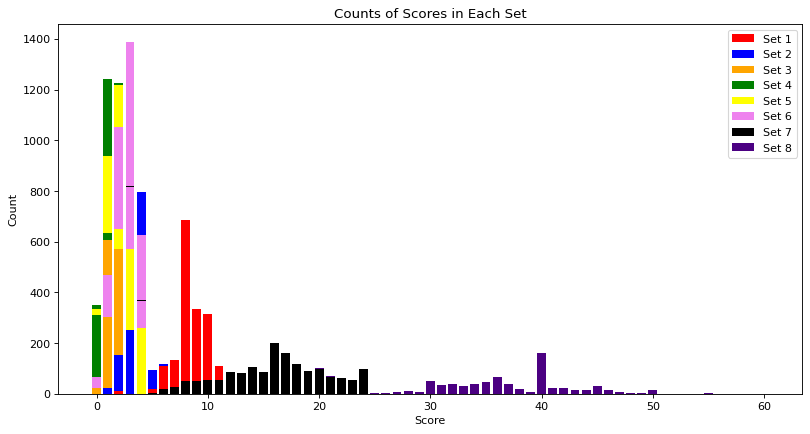

In [ ]:
set1_counts = asap_train[asap_train["essay_set"]==1]["domain1_score"].value_counts(dropna=False).reset_index()
set2_counts = asap_train[asap_train["essay_set"]==2]["domain1_score"].value_counts(dropna=False).reset_index()
set3_counts = asap_train[asap_train["essay_set"]==3]["domain1_score"].value_counts(dropna=False).reset_index()
set4_counts = asap_train[asap_train["essay_set"]==4]["domain1_score"].value_counts(dropna=False).reset_index()
set5_counts = asap_train[asap_train["essay_set"]==5]["domain1_score"].value_counts(dropna=False).reset_index()
set6_counts = asap_train[asap_train["essay_set"]==6]["domain1_score"].value_counts(dropna=False).reset_index()
set7_counts = asap_train[asap_train["essay_set"]==7]["domain1_score"].value_counts(dropna=False).reset_index()
set8_counts = asap_train[asap_train["essay_set"]==8]["domain1_score"].value_counts(dropna=False).reset_index()

possible_scores = range(0,61,1)
use = pd.DataFrame(possible_scores, columns=["score"])

set1 = use.merge(set1_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set1.fillna(0, inplace=True)

set2 = use.merge(set2_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set2.fillna(0, inplace=True)

set3 = use.merge(set3_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set3.fillna(0, inplace=True)

set4 = use.merge(set4_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set4.fillna(0, inplace=True)

set5 = use.merge(set5_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set5.fillna(0, inplace=True)

set6 = use.merge(set6_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set6.fillna(0, inplace=True)

set7 = use.merge(set7_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set7.fillna(0, inplace=True)

set8 = use.merge(set8_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set8.fillna(0, inplace=True)


x = set1["score"]
y1 = set1["count"]
y2 = set2["count"]
y3 = set3["count"]
y4 = set4["count"]
y5 = set5["count"]
y6 = set6["count"]
y7 = set7["count"]
y8 = set8["count"]

plt.figure(figsize=(12, 6), dpi=80)
plt.bar(x, y1, color='r', label="Set 1")
plt.bar(x, y2, bottom=y1, color='b', label="Set 2")
plt.bar(x, y3, bottom=y2, color='orange', label="Set 3")
plt.bar(x, y4, bottom=y3, color='green', label="Set 4")
plt.bar(x, y5, bottom=y4, color='yellow', label="Set 5")
plt.bar(x, y6, bottom=y5, color='violet', label="Set 6")
plt.bar(x, y7, bottom=y6, color='black', label="Set 7")
plt.bar(x, y8, bottom=y7, color='indigo', label="Set 8")
plt.legend(loc='upper right')
plt.title("Counts of Scores in Each Set")
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## Choose one of these blocks to run.

This will decide which set(s) are in the training/validation and which set(s) are in the test. This mimics what will happen if the prompts and scoring system are changed year to year even though the scoring system mostly stays the same.

In [ ]:
cutoff = 1

In [ ]:
cutoff = 2

In [ ]:
cutoff = 3

In [ ]:
cutoff = 4

In [ ]:
cutoff = 5

In [ ]:
cutoff = 6

In [ ]:
cutoff = 7

## Continue With Setup

In [ ]:
x_train = asap_train[asap_train["essay_set"]<=cutoff]["essay"]
y_train1 = asap_train[asap_train["essay_set"]<=cutoff]["domain1_score"]

x_test = asap_train[asap_train["essay_set"]>cutoff]["essay"]
y_test1 = asap_train[asap_train["essay_set"]>cutoff]["domain1_score"]

In [ ]:
x_test_ell = ell_test_fin['full_text']

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Tokenizing and Model Selection

In [ ]:
batch_size = 32

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
input_ids = []
attention_masks = []

for essay in x_train:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        padding = 'max_length',
                        truncation = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

In [ ]:
input_ids_test = []
attention_masks_test = []

for essay in x_test:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        max_length = 512,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

input_ids_test = torch.cat(input_ids_test, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

In [ ]:
input_ids_ell = []
attention_masks_ell = []

for essay in x_test_ell:
    encoded_dict = tokenizer.encode_plus(
                        essay,
                        add_special_tokens = True,
                        max_length = 512,
                        padding = 'max_length',
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    input_ids_ell.append(encoded_dict['input_ids'])
    attention_masks_ell.append(encoded_dict['attention_mask'])

input_ids_ell = torch.cat(input_ids_ell, dim=0)
attention_masks_ell = torch.cat(attention_masks_ell, dim=0)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
labels = torch.tensor(y_train1.values)
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

In [ ]:
num_outputs_possible_d1 = max(max(y_train1),max(y_test1))+1
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased",
    num_labels = num_outputs_possible_d1,
    output_attentions = False,
    output_hidden_states = False,
)
model.cuda()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

Even though I suspect 3 epochs to be too much given the results of the second workbook, I decided to continue using 3 epochs for contintuity's sake when creating similar models.

In [ ]:
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# Fine-tuning with Set(s) __

I will start with Set 1 and then progressively add sets into the training data while using the rest of the sets as test data. This is to mimic what would happen if similar essays were added year-to-year, but with different prompts.

## Set 1

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']
        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats


======== Epoch 1 / 3 ========
Training...
  Batch    40  of     51.    Elapsed: 0:02:01.

  Average training loss: 2.99
  Training epoch took: 0:02:35

Running Validation...
  Accuracy: 0.42
  Validation Loss: 2.15
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...
  Batch    40  of     51.    Elapsed: 0:02:06.

  Average training loss: 1.96
  Training epoch took: 0:02:41

Running Validation...
  Accuracy: 0.50
  Validation Loss: 1.64
  Validation took: 0:00:06

======== Epoch 3 / 3 ========
Training...
  Batch    40  of     51.    Elapsed: 0:02:07.

  Average training loss: 1.59
  Training epoch took: 0:02:41

Running Validation...
  Accuracy: 0.55
  Validation Loss: 1.53
  Validation took: 0:00:06

Training complete!


,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.99,2.15,0.42,0:02:35,0:00:06
2,1.96,1.64,0.50,0:02:41,0:00:06
3,1.59,1.53,0.55,0:02:41,0:00:06


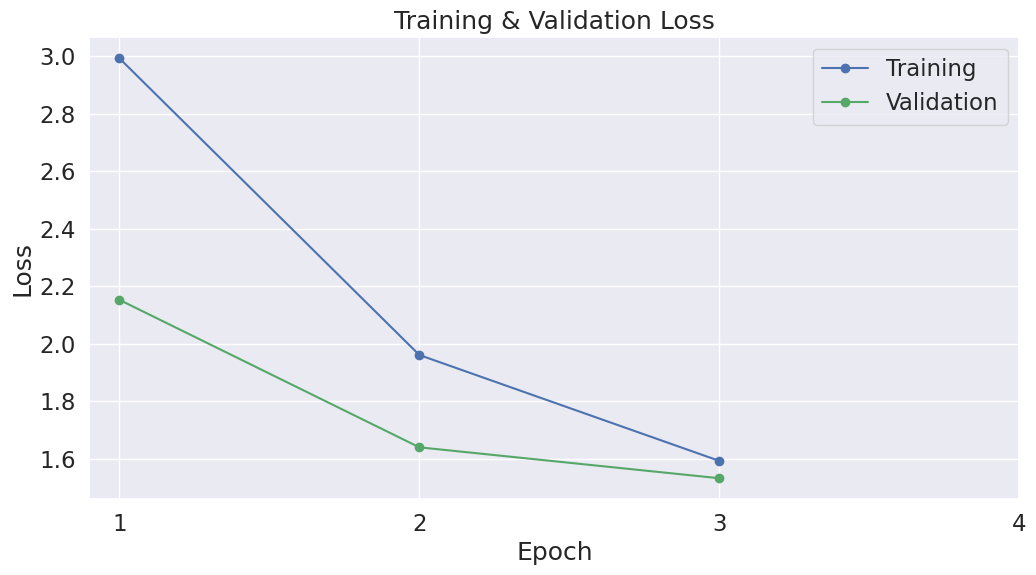

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

As with the previous workbook, it is likely that the model is beginning to overfit.

### ASAP Test (Sets 2-8)

In [ ]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))
model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

print(f'length: {len(predictions)}')
print(f'shape of each array: {predictions[0].shape}')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

Predicting labels for 11,193 test sentences...
    DONE.
length: 350
shape of each array: (32, 61)


In [ ]:
accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

0.001876172607879925
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       418
           1       0.00      0.00      0.00      1736
           2       0.00      0.00      0.00      2435
           3       0.00      0.00      0.00      2829
           4       0.00      0.00      0.00      1407
           5       0.00      0.00      0.00        79
           6       0.00      0.74      0.01        27
           7       0.00      0.00      0.00        28
           8       0.00      0.02      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        56
          12       0.00      0.00      0.00        86
          13       0.00      0.00      0.00        82
          14       0.00      0.00      0.00       105
          15       0.00      0.00      0.00        86
          16       0.00      0.00      0.00       199
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The accuracy is very poor: less than 1%. It is possible that there isn't enough data so that the model can't correctly generalize.

### ELLIPSE Test Set

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)

In [ ]:
flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([ 8,  8,  8,  8,  8,  9,  8,  8,  6,  8,  8,  8,  9,  9,  8,  8,  9,
        8,  8,  8,  8,  8,  8,  8,  8,  8, 10,  8,  8,  8,  8,  8,  8, 10,
        8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8, 10,  8,  8,  8,
        6,  8,  8,  6,  8, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8,  8,  8,
        8,  6,  8,  8,  8,  6,  8,  6,  6,  6,  6,  8,  8,  6,  8,  8,  8,
        8,  9,  8,  8,  8,  8,  8,  8,  6,  8,  9,  8,  8,  8,  8,  8,  6,
        8,  8,  8,  8,  9,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,
        6, 10,  8,  8,  8,  8,  8,  8,  8,  6,  6,  8,  8,  6,  6,  8,  6,
        8,  8,  8,  8, 10,  8,  8,  8,  6,  8,  8,  6,  8,  8, 10,  8,  8,
        8,  6,  8,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  8,  6,  8,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  6,  6,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  6

### Distribution Comparisons

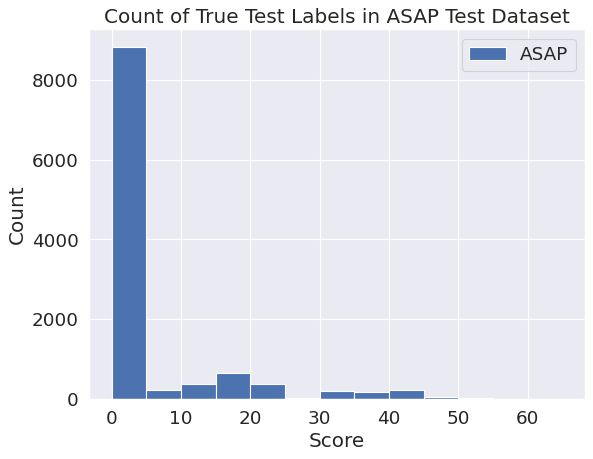

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

There is a strong right skew.

In [ ]:
flat_predictions.shape

(11193,)

In [ ]:
flat_predictions_ell.shape

(774,)

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

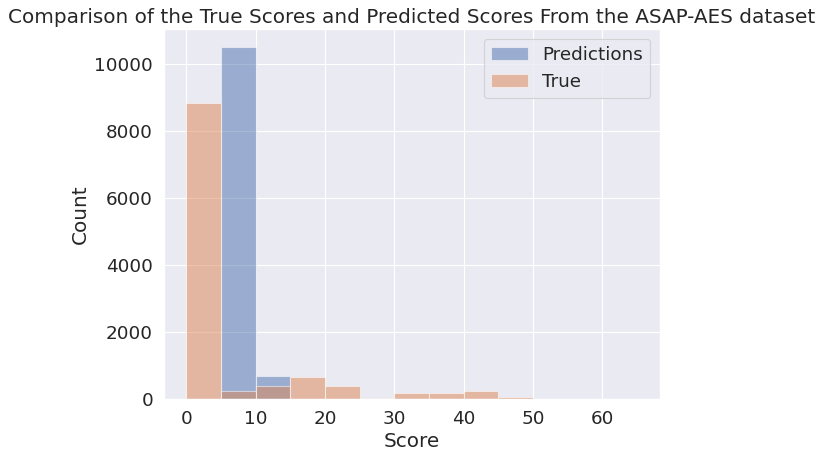

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The model struggled to predict scores above 15, but isn't predicting the scores to be as low as they truly are.

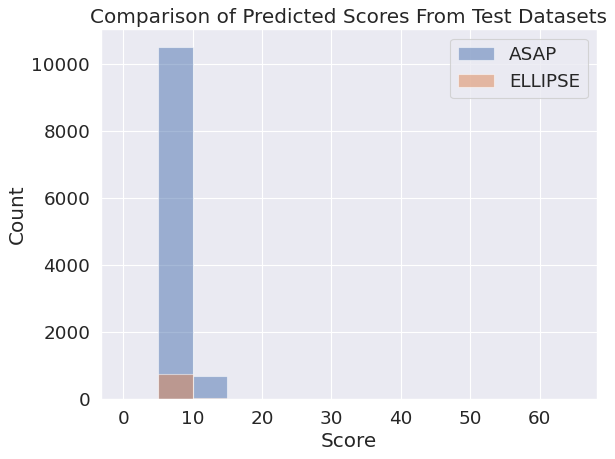

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Looking at the x-axis, we see that most of the predicted labels are between 5 and 10. The model is consistently predicting higher values. The ELLIPSE scores are all within 5 and 10.

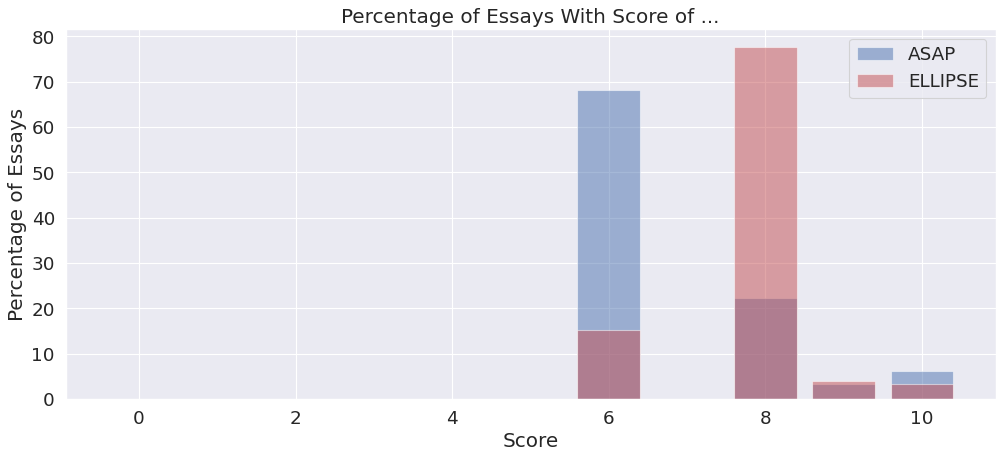

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100

a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

Looking at proportions helps compare the two distributions because the histogram of the counts misrepresents the data slightly as the test set of the ASAP dataset is so large compared to the ELLIPSE corpus. The distribution of ELLIPSE scores still has a right skew, but it is not as extreme as the ASAP scores. A greater proportion of ELLISPE scores are higher than the ASAP scores.

In [ ]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: -22.14948352105491
P-value: 1.4394674172829307e-106


There is a significant difference between the two essay sets.

## Sets 1-2

I am resetting the seed here because holding both models in memory may go over the free tier for Google Colab.

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    101.    Elapsed: 0:01:51.
  Batch    80  of    101.    Elapsed: 0:03:44.

  Average training loss: 2.48
  Training epoch took: 0:04:43

Running Validation...
  Accuracy: 0.57
  Validation Loss: 1.60
  Validation took: 0:00:11

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    101.    Elapsed: 0:01:51.
  Batch    80  of    101.    Elapsed: 0:03:44.

  Average training loss: 1.45
  Training epoch took: 0:04:43

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.30
  Validation took: 0:00:11

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    101.    Elapsed: 0:01:51.
  Batch    80  of    101.    Elapsed: 0:03:44.

  Average training loss: 1.24
  Training epoch took: 0:04:43

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.22
  Validation took: 0:00:11

Training complete!


In [ ]:
pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.48,1.60,0.57,0:04:43,0:00:11
2,1.45,1.30,0.59,0:04:43,0:00:11
3,1.24,1.22,0.59,0:04:43,0:00:11


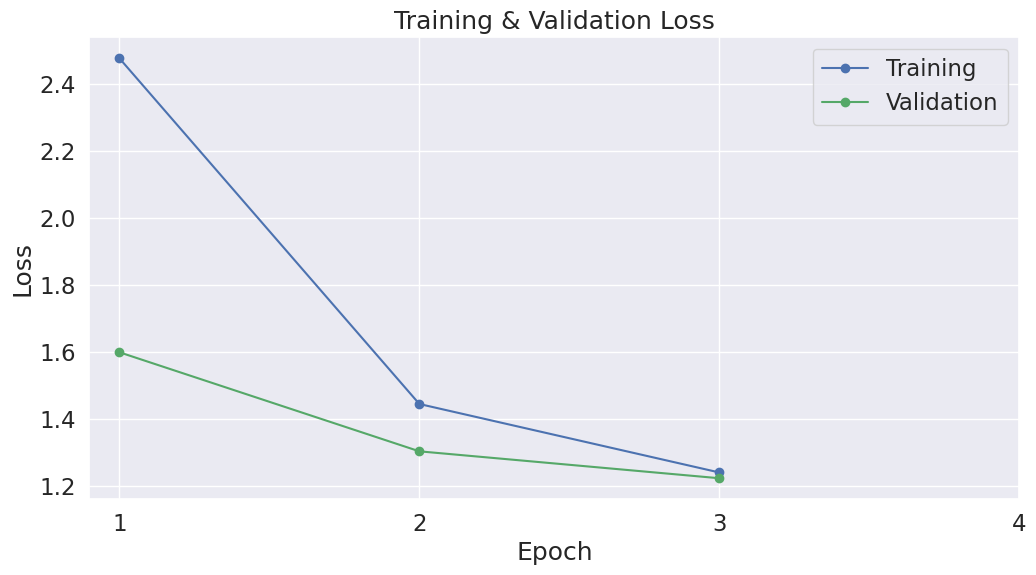

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

As with the second workbook, it is likely that the model is beginning to overfit.

### ASAP Test (Sets 3-8)

In [ ]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

Predicting labels for 9,393 test sentences...
    DONE.
0.20525923560097944
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       418
           1       0.00      0.00      0.00      1712
           2       0.00      0.00      0.00      2282
           3       0.24      0.92      0.37      2066
           4       0.17      0.04      0.07       629
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        28
           8       0.00      0.04      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        56
          12       0.00      0.00      0.00        86
          13       0.00      0.00      0.00        82
          14       0.00      0.00      0.00       105
          15       0.00      0.00      0.00        86
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The accuracy jumped to 20.5% from less than 1%. This suggests to me that adding more examples helps the model.

### ELLIPSE Test Set

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)


flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([ 8,  3,  8,  3,  3,  8,  8,  8,  3,  3,  8,  3,  9,  8,  8,  8,  8,
        3,  3,  8,  3,  8,  3,  8,  3,  4,  4,  8,  8,  3,  3,  8,  3,  9,
        3,  3,  8,  8,  3,  8,  8,  8,  3,  8,  4,  3,  4,  9,  3,  3,  8,
        3,  8,  4,  3,  8,  9,  4,  8,  3,  8,  8,  3,  8,  3,  3,  8,  8,
        8, 10,  3,  8,  4,  8,  3,  8,  8,  8,  8,  3,  3,  3,  8,  3,  8,
        3,  3,  3,  8,  3,  3,  8,  3,  3,  3,  3,  8,  4,  3,  3,  3,  8,
        3,  4,  8,  3,  8,  8,  3,  8,  3,  3,  8,  3,  3,  3,  3,  8,  3,
        3,  8,  3,  8,  8,  3,  3,  8,  8,  4,  8,  3,  8,  8,  3,  8,  8,
        3, 10,  3,  8,  8,  8,  4,  3,  3,  3,  3,  3,  8,  3,  3,  8,  3,
        3,  8,  8,  8,  9,  8,  8,  3,  3,  4,  3,  3,  8,  3,  4,  3,  3,
        3,  3,  8,  8,  3,  8,  8,  3,  3,  8,  8,  4,  3,  8,  3,  4,  8,
        4,  3,  8,  8,  8,  3,  8,  3,  4,  3,  3,  3,  8,  3,  8,  8,  4,
        8,  3,  3,  8,  4,  3,  3,  3,  3,  4,  3,  8,  8,  8,  8,  3,  3,
        8,  8,  8,  4,  3

### Distribution Comparisons

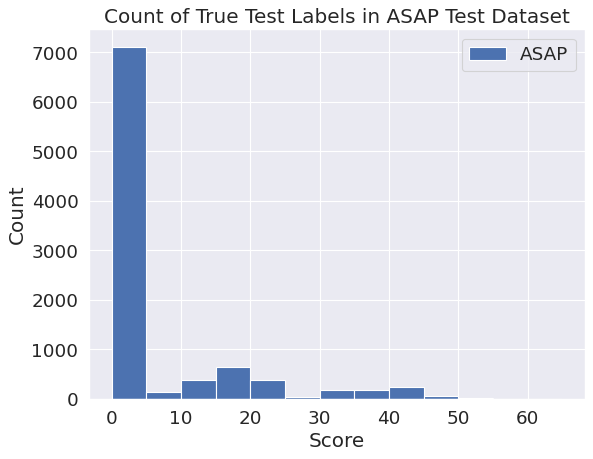

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

There are scores that are above 10, but they make up a small proportion of the test data.

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

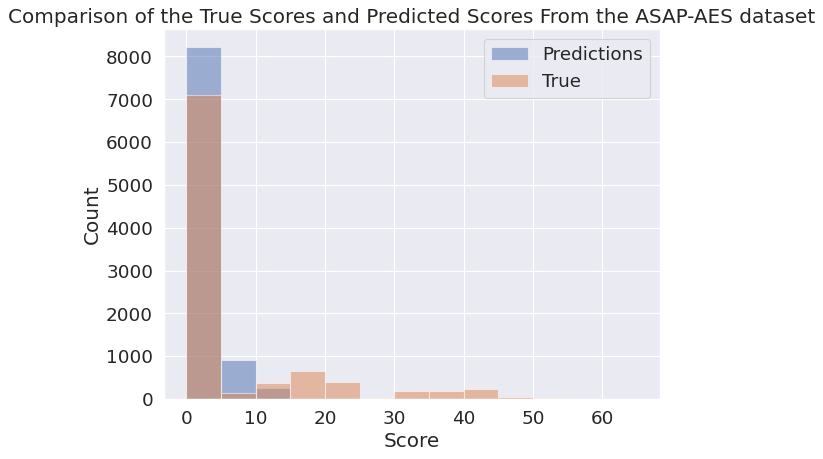

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

With the inclusion of the Set 2 data, thehe model has learned to predict lower scores, thus the higher accuracy. A few of the predictions in the 10-14 bin are making it in.

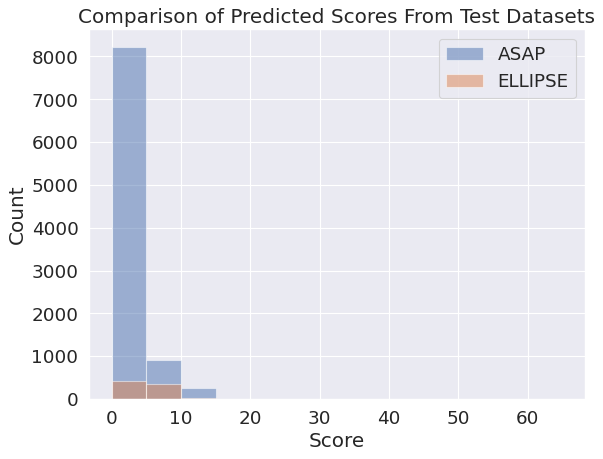

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The model generally predicts scores between 1-9. For the ASAP dataset, it can predict scores between 10-14, but does not predict any score above 15.

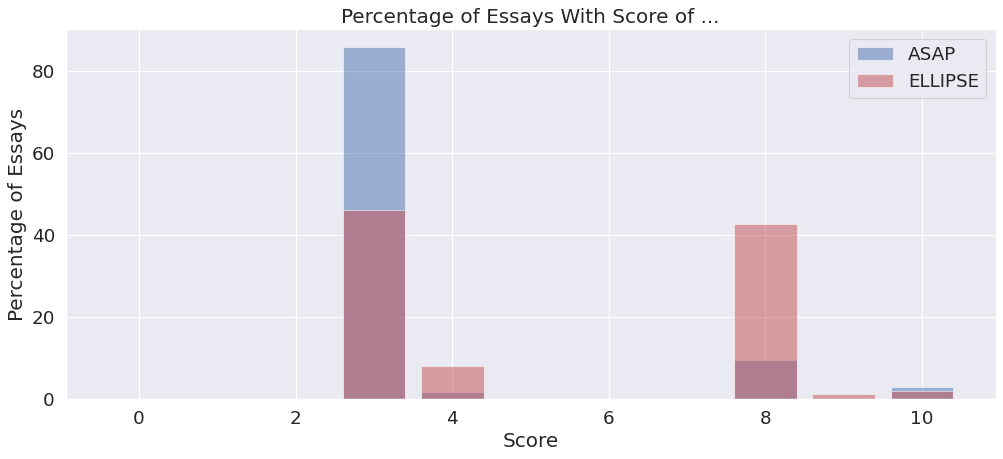

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100


a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

As with the previous model, using the percentages will prevent the ELLIPSE proportions from being misrepresented. The ASAP scores have a strong right skew, but the ELLIPSE scores are split between 3 and 8 being the most predicted scores.

In [ ]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: -24.50097553746276
P-value: 7.505308327822857e-129


The predictions of these two datasets are significantly different from each other. The ELLIPSE scores are higher than the ASAP-AES scores.

## Sets 1-3

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    150.    Elapsed: 0:01:55.
  Batch    80  of    150.    Elapsed: 0:03:52.
  Batch   120  of    150.    Elapsed: 0:05:50.

  Average training loss: 2.11
  Training epoch took: 0:07:18

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.30
  Validation took: 0:00:16

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    150.    Elapsed: 0:01:56.
  Batch    80  of    150.    Elapsed: 0:03:54.
  Batch   120  of    150.    Elapsed: 0:05:52.

  Average training loss: 1.18
  Training epoch took: 0:07:19

Running Validation...
  Accuracy: 0.61
  Validation Loss: 1.10
  Validation took: 0:00:16

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    150.    Elapsed: 0:01:56.
  Batch    80  of    150.    Elapsed: 0:03:54.
  Batch   120  of    150.    Elapsed: 0:05:52.

  Average training loss: 1.03
  Training epoch took: 0:07:20

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.05
  Validation too

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,2.11,1.30,0.56,0:07:18,0:00:16
2,1.18,1.10,0.61,0:07:19,0:00:16
3,1.03,1.05,0.62,0:07:20,0:00:16


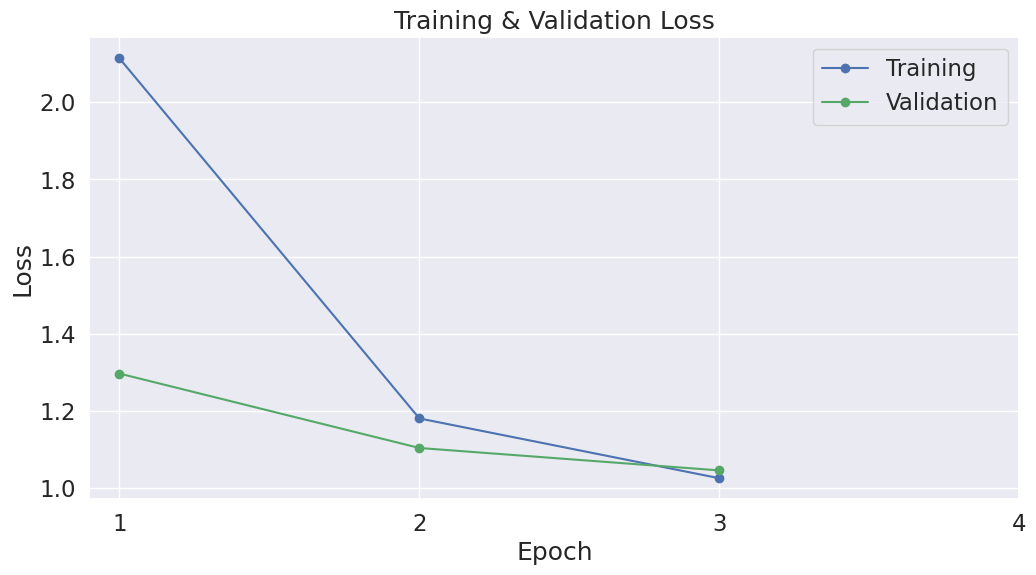

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

This model has begun to overfit at 3 epochs.

In [ ]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

### ASAP Test (Sets 4-8)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

Predicting labels for 7,667 test sentences...
    DONE.
0.3889396113212469
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       379
           1       0.42      0.72      0.53      1105
           2       0.41      0.65      0.50      1625
           3       0.43      0.68      0.52      1643
           4       0.05      0.02      0.03       629
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        56
          12       0.00      0.00      0.00        86
          13       0.00      0.00      0.00        82
          14       0.00      0.00      0.00       105
          15       0.00      0.00      0.00        86
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The accuracy, again, increases with more training data: 38.9%. The accuracy increases even though the model is overfitting.

### ELLIPSE  Test Set

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)


flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([ 8,  3, 10,  3,  8, 10, 10, 10,  3,  8,  8,  8, 10, 10,  3,  8,  4,
        3,  8,  8,  3,  8,  3,  8,  3,  8,  4,  8, 10,  8,  8,  8,  3, 10,
        3,  1,  8,  8,  3,  8,  3,  8,  3,  8,  3,  2,  3, 10,  3,  2,  8,
        3,  8,  3,  1,  8,  4,  4,  8,  3,  8,  8,  3,  3,  3,  3,  8,  8,
        3, 10,  3,  8,  3,  8,  3,  8,  8,  8, 10,  3,  3,  3,  3,  3,  3,
        8,  2,  3,  8,  8,  2,  3,  3,  2,  1,  3,  4,  3,  1,  3,  3,  3,
        7,  4,  3,  3,  8,  3,  8,  8,  2,  3, 10,  3,  8,  1,  3,  8,  3,
        8, 10,  3,  8, 10,  3,  8,  8,  6,  3,  4,  3,  8,  8,  1,  8, 10,
        2, 10,  3, 10, 10, 10,  3,  3,  3,  1,  1,  3,  8,  2,  1,  8,  3,
        8,  8,  3, 10,  4,  8,  8,  3,  2,  3,  8,  3,  8,  8,  4,  3,  3,
        3,  2,  8,  8,  3,  8, 10,  2,  8,  3,  8,  3,  3,  3,  7,  3,  3,
        3,  3,  8, 10,  3,  1,  4,  3,  3,  3,  1,  3,  8,  8,  8,  3,  3,
        3,  8,  3,  3,  3,  3,  1,  2,  3,  3,  3,  8,  8,  4,  8,  3,  2,
        8,  3,  8,  3,  2

### Distribution Comparisons

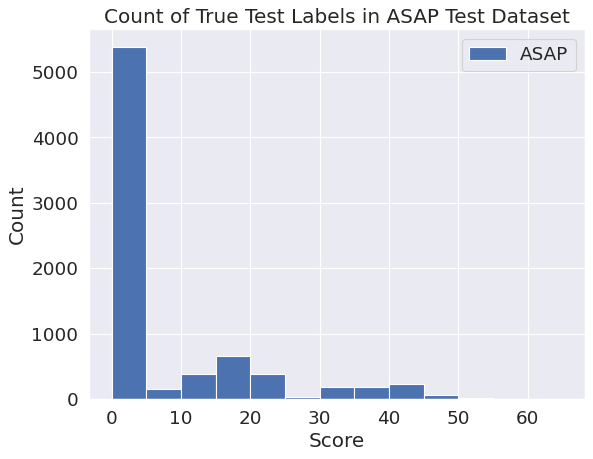

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

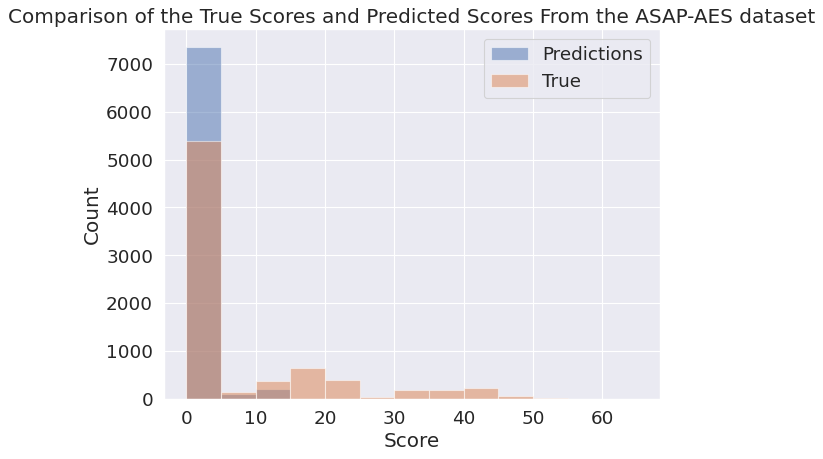

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The model is learning to predict scores between 0 and 4, and can predict slightly higher scores, but the strong imbalance in the training data makes it difficult to predict higher scores.

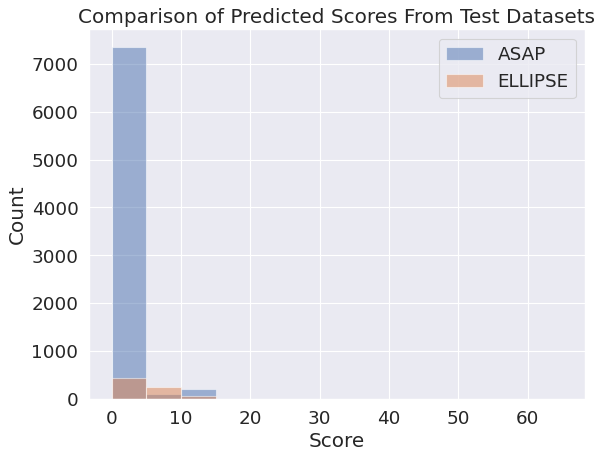

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Despite the fact that the right skew remains in the ASAP-AES scores, the model is beginning to predict more than one number when it is predicting a number that is less than 5. The model is a bit more flexible with its data predictions, even if it is still largely inaccurate.

The ELLIPSE score distribution also has a right skew. This is just a graph of the counts though.

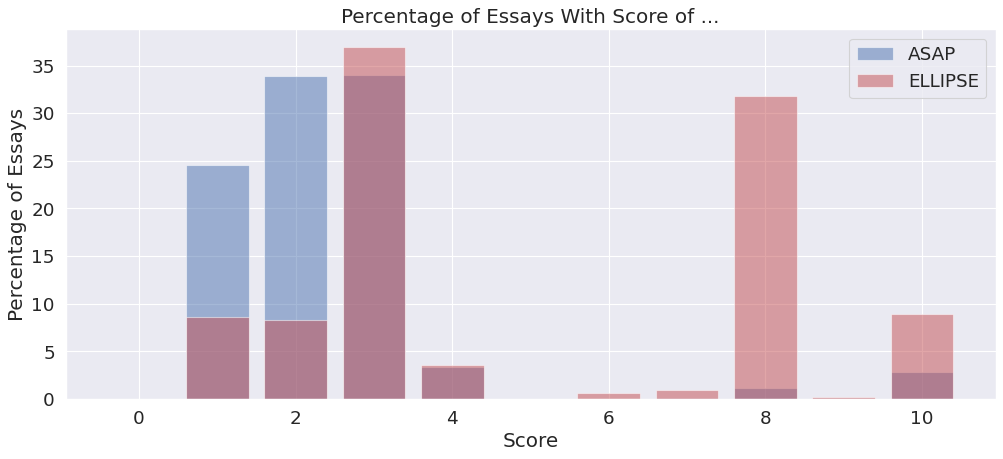

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100


a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

When the graph is converted to a graph of percentages, the predicted ELLIPSE scores are bimodal: 3 and 8. This is similar to the previous models. It is no longer a right skew when the scores aren't grouped together in bins. The model is able to predict about the same percentage for essays with 2 and 3, as well as almost 25% for scores of 1.

In [ ]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: -37.75263418997691
P-value: 2.4429841697455183e-288


The ELLIPSE essays continue to have a higher predicted score average compared to the ASAP-AES predicted scores.

## Sets 1-4

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    200.    Elapsed: 0:01:48.
  Batch    80  of    200.    Elapsed: 0:03:42.
  Batch   120  of    200.    Elapsed: 0:05:35.
  Batch   160  of    200.    Elapsed: 0:07:29.

  Average training loss: 1.89
  Training epoch took: 0:09:21

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.17
  Validation took: 0:00:20

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    200.    Elapsed: 0:01:52.
  Batch    80  of    200.    Elapsed: 0:03:45.
  Batch   120  of    200.    Elapsed: 0:05:39.
  Batch   160  of    200.    Elapsed: 0:07:32.

  Average training loss: 1.06
  Training epoch took: 0:09:24

Running Validation...
  Accuracy: 0.60
  Validation Loss: 1.01
  Validation took: 0:00:20

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    200.    Elapsed: 0:01:52.
  Batch    80  of    200.    Elapsed: 0:03:45.
  Batch   120  of    200.    Elapsed: 0:05:38.
  Batch   160  of    200.    Elapsed: 0:07:31.



,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.89,1.17,0.58,0:09:21,0:00:20
2,1.06,1.01,0.60,0:09:24,0:00:20
3,0.91,0.99,0.63,0:09:24,0:00:20


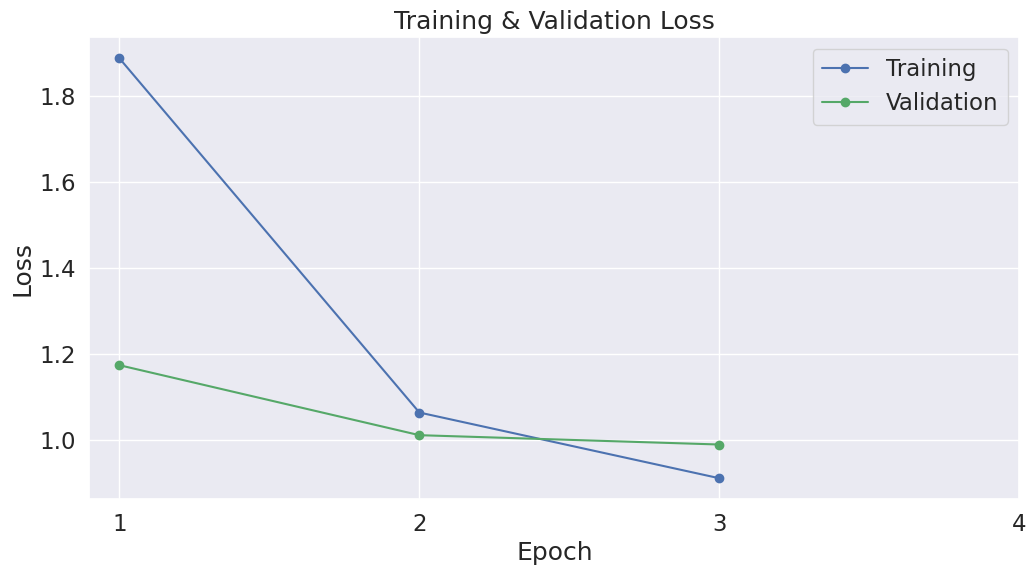

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

The loss decreased in comparison to the previous models with fewer sets, but it is overfitting.

### ASAP Test (Sets 5-8)

In [ ]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

Predicting labels for 5,897 test sentences...
    DONE.
0.2999830422248601
              precision    recall  f1-score   support

           0       0.25      0.12      0.16        68
           1       0.31      0.63      0.41       469
           2       0.29      0.55      0.37      1055
           3       0.37      0.63      0.47      1390
           4       0.05      0.02      0.03       629
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        56
          12       0.00      0.00      0.00        86
          13       0.00      0.00      0.00        82
          14       0.00      0.00      0.00       105
          15       0.00      0.00      0.00        86
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The accuracy decreased to about 30.0%. This shows that simply adding more training data to models doesn't necessarily improve its performance. The model and hyperparameters would need to be re-evaluated every time the training data is updated.

### ELLIPSE Test Set

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)


flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([ 4,  3,  4,  3,  3,  4,  4,  4,  2,  3,  4,  3,  4,  4,  3,  8,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  4,  3,  3,  4,  3,  4,
        3,  3,  8,  3,  3,  3,  3,  3,  3,  3,  3,  2,  4,  4,  3,  3,  3,
        3,  3,  3,  2,  3,  4,  4,  3,  2,  3,  8,  3,  3,  3,  3,  3,  3,
        3,  4,  3,  3,  3,  3,  3,  3,  3,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  3,  3,  2,  2,  1,  3,  4,  3,  1,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  2,  3,  3,
        3,  4,  3,  8,  4,  3,  3,  3,  3,  3,  4,  3,  3,  3,  2,  8,  4,
        2, 10,  3,  4,  4,  4,  3,  3,  3,  3,  2,  3,  3,  3,  2,  3,  3,
        3,  3,  3,  4,  4,  3,  8,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,
        3,  2,  3,  3,  3,  8,  3,  2,  3,  3,  3,  4,  2,  3,  3,  3,  3,
        4,  3,  3, 10,  3,  2,  4,  3,  4,  3,  2,  3,  3,  3,  8,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  3,  3,  8,  4,  3,  2,  3,
        3,  3,  8,  4,  2

### Distribution Comparisons

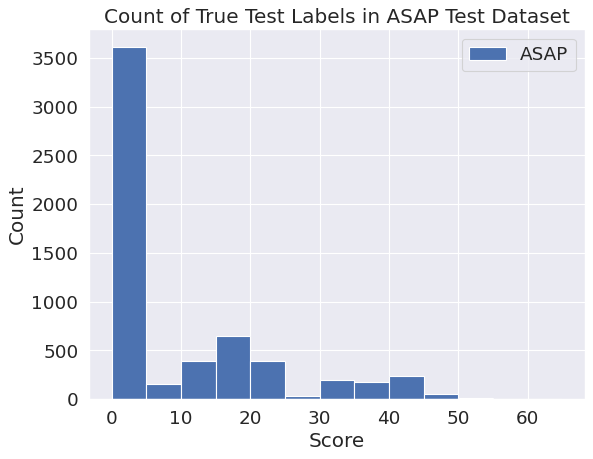

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

There is an increased proportion of the data that receives a score above 10 even though there is still a very strong right skew.

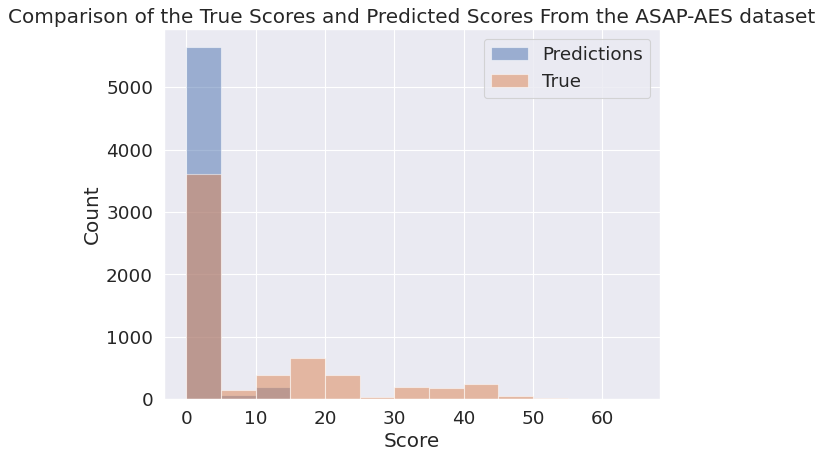

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The model is still not learning to predict scorres above 15 and continues to mostly predict scores between 0 and 4.

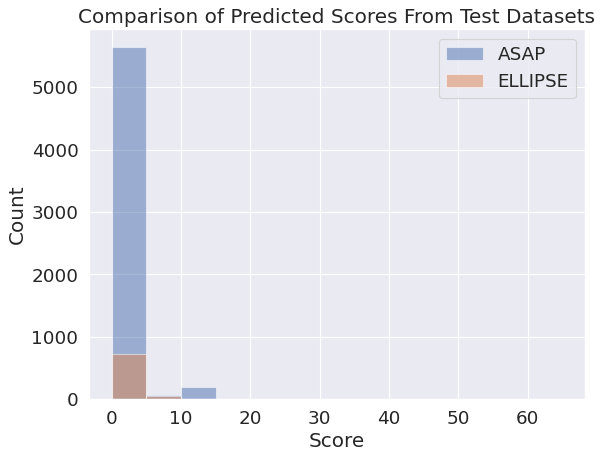

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

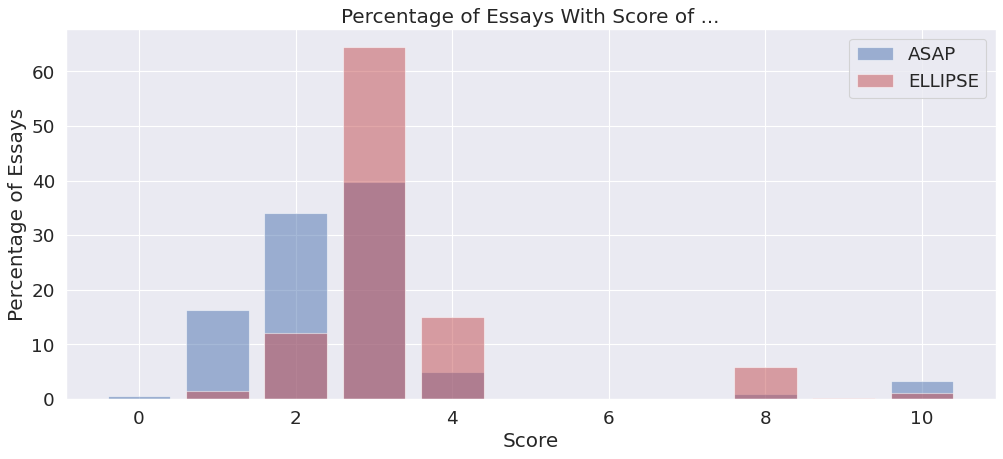

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100


a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

The model generally predicts scores of 2-4. This reflects the fact that most of the essay scores are 5 or less in the training data. The predicted ELLIPSE scores are generally larger than the predicted ASAP-AES scores.

In [ ]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: -11.518830938161098
P-value: 2.053998116532626e-30


There is a statistically significant difference between the averages of the predicted scores of the two datasets. The predicted ELLIPSE scores are generally larger.

## Sets 1-5

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    250.    Elapsed: 0:01:48.
  Batch    80  of    250.    Elapsed: 0:03:42.
  Batch   120  of    250.    Elapsed: 0:05:36.
  Batch   160  of    250.    Elapsed: 0:07:30.
  Batch   200  of    250.    Elapsed: 0:09:24.
  Batch   240  of    250.    Elapsed: 0:11:18.

  Average training loss: 1.68
  Training epoch took: 0:11:46

Running Validation...
  Accuracy: 0.63
  Validation Loss: 1.02
  Validation took: 0:00:27

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    250.    Elapsed: 0:01:52.
  Batch    80  of    250.    Elapsed: 0:03:46.
  Batch   120  of    250.    Elapsed: 0:05:40.
  Batch   160  of    250.    Elapsed: 0:07:33.
  Batch   200  of    250.    Elapsed: 0:09:27.
  Batch   240  of    250.    Elapsed: 0:11:21.

  Average training loss: 0.96
  Training epoch took: 0:11:49

Running Validation...
  Accuracy: 0.64
  Validation Loss: 0.91
  Validation took: 0:00:27

======== Epoch 3 / 3 ========
Training...
 

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.68,1.02,0.63,0:11:46,0:00:27
2,0.96,0.91,0.64,0:11:49,0:00:27
3,0.83,0.89,0.67,0:11:49,0:00:27


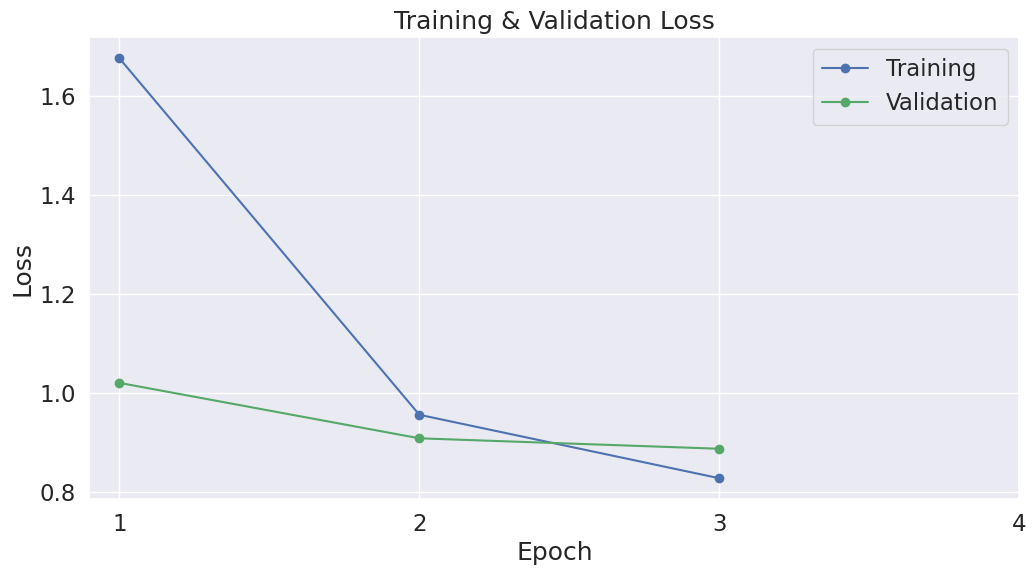

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

The model is overfitting.

### ASAP Test (Sets 6-8)

In [ ]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

Predicting labels for 4,092 test sentences...
    DONE.
0.21578690127077224
              precision    recall  f1-score   support

           0       0.14      0.07      0.09        44
           1       0.11      0.51      0.18       167
           2       0.21      0.64      0.31       406
           3       0.35      0.64      0.45       818
           4       0.03      0.04      0.04       371
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        28
           8       0.00      0.00      0.00        50
           9       0.00      0.00      0.00        49
          10       0.00      0.00      0.00        56
          11       0.00      0.00      0.00        56
          12       0.00      0.00      0.00        86
          13       0.00      0.00      0.00        82
          14       0.00      0.00      0.00       105
          15       0.00      0.00      0.00        86
     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The accuracy further drops to 21.6%. This shows that beyond a point, adding more data doesn't necessarily help with model accuracy.

### ELLIPSE Test Set

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)


flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([ 4,  3,  4,  3,  3,  4,  4,  4,  2,  3,  4,  3,  4,  4,  3,  4,  4,
        3,  3,  3,  3,  3,  3,  4,  3,  3,  4,  3,  4,  3,  3,  4,  3,  4,
        2,  2,  3,  3,  3,  4,  4,  3,  3,  3,  4,  1,  4,  4,  3,  3,  3,
        3,  3,  3,  1,  4,  4,  4,  3,  2,  3,  8,  3,  4,  3,  3,  3,  3,
        3,  4,  3,  4,  4,  3,  3,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  2,  3,  2,  2,  1,  2,  4,  3,  1,  3,  3,  3,
        8,  4,  3,  3,  3,  3,  3,  3,  2,  3,  4,  3,  3,  3,  3,  3,  2,
        3,  4,  3,  4,  4,  3,  3,  3,  2,  4,  4,  3,  3,  3,  1,  4,  4,
        2, 10,  3,  4,  4,  4,  3,  3,  3,  2,  2,  3,  3,  2,  1,  3,  2,
        3,  3,  3,  4,  4,  3,  3,  2,  2,  4,  3,  3,  4,  3,  4,  3,  3,
        3,  2,  3,  3,  3,  3,  4,  2,  3,  3,  4,  4,  2,  3,  2,  3,  4,
        4,  3,  3,  4,  3,  2,  4,  3,  4,  3,  1,  3,  4,  3,  8,  3,  4,
        4,  3,  3,  4,  3,  2,  1,  2,  3,  3,  3,  3,  8,  4,  3,  3,  2,
        3,  3,  8,  4,  2

### Distribution Comparisons

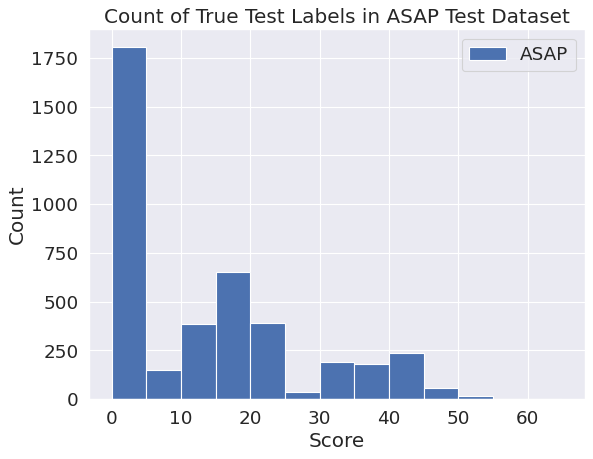

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

There is an increasing proportion of the test data that receives a score above 10. Scores between 15 and 20 should receive the second-most scores.

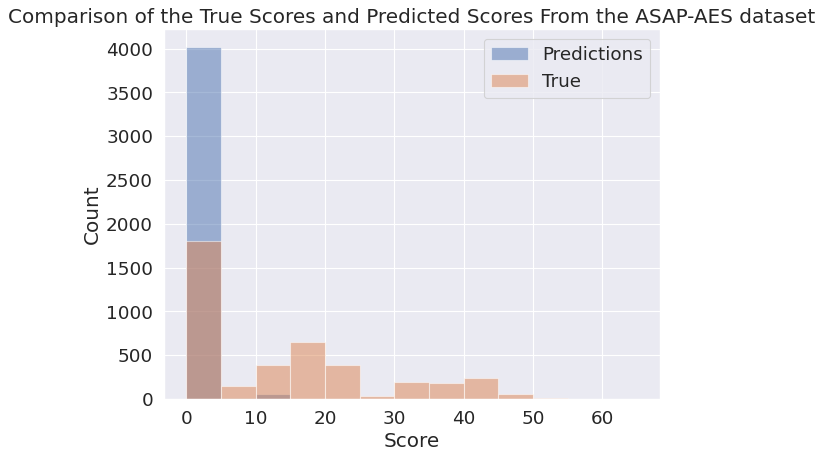

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Unfortunately, the model has learned to generally predict scores between 0 and 4. This results in plumetting accuracy and a lower variety of scores.

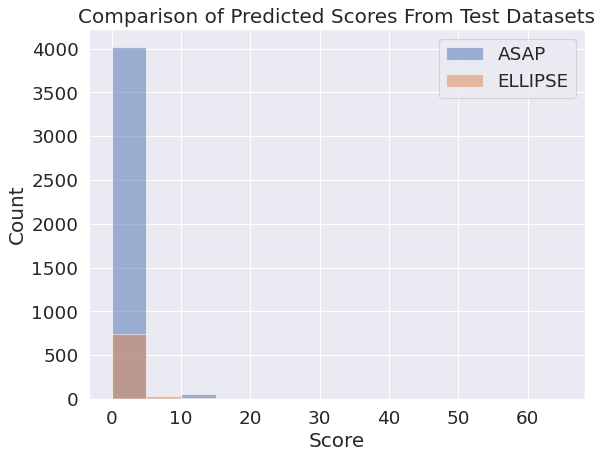

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The model is mostly predicting scores between 1 and 4 for both datasets. It struggles to predict scores between 5 and 14, and does not predict any scores higher than 15.

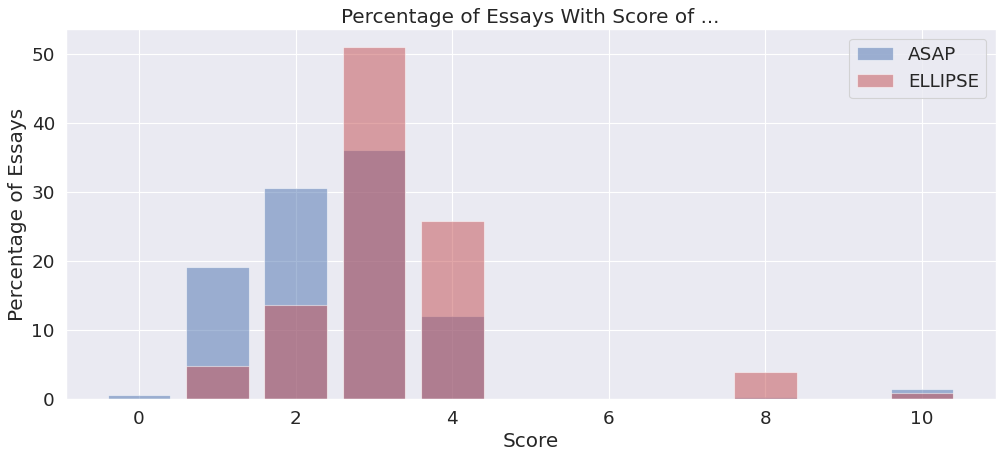

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100


a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

Again, the ELLIPSE scores generally receive a larger proportion of higher scores as compared to the ASAP scores.

In [ ]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: -14.031698438774473
P-value: 7.080832338730352e-44


The difference between the average scores of the two populations is still statistically significant.

## Sets 1-6

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    301.    Elapsed: 0:01:49.
  Batch    80  of    301.    Elapsed: 0:03:42.
  Batch   120  of    301.    Elapsed: 0:05:35.
  Batch   160  of    301.    Elapsed: 0:07:28.
  Batch   200  of    301.    Elapsed: 0:09:21.
  Batch   240  of    301.    Elapsed: 0:11:13.
  Batch   280  of    301.    Elapsed: 0:13:06.

  Average training loss: 1.53
  Training epoch took: 0:14:05

Running Validation...
  Accuracy: 0.62
  Validation Loss: 1.01
  Validation took: 0:00:31

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    301.    Elapsed: 0:01:51.
  Batch    80  of    301.    Elapsed: 0:03:44.
  Batch   120  of    301.    Elapsed: 0:05:36.
  Batch   160  of    301.    Elapsed: 0:07:29.
  Batch   200  of    301.    Elapsed: 0:09:22.
  Batch   240  of    301.    Elapsed: 0:11:15.
  Batch   280  of    301.    Elapsed: 0:13:08.

  Average training loss: 0.91
  Training epoch took: 0:14:07

Running Validation...
  Accuracy: 0.64
 

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.53,1.01,0.62,0:14:05,0:00:31
2,0.91,0.90,0.64,0:14:07,0:00:31
3,0.78,0.87,0.67,0:14:07,0:00:31


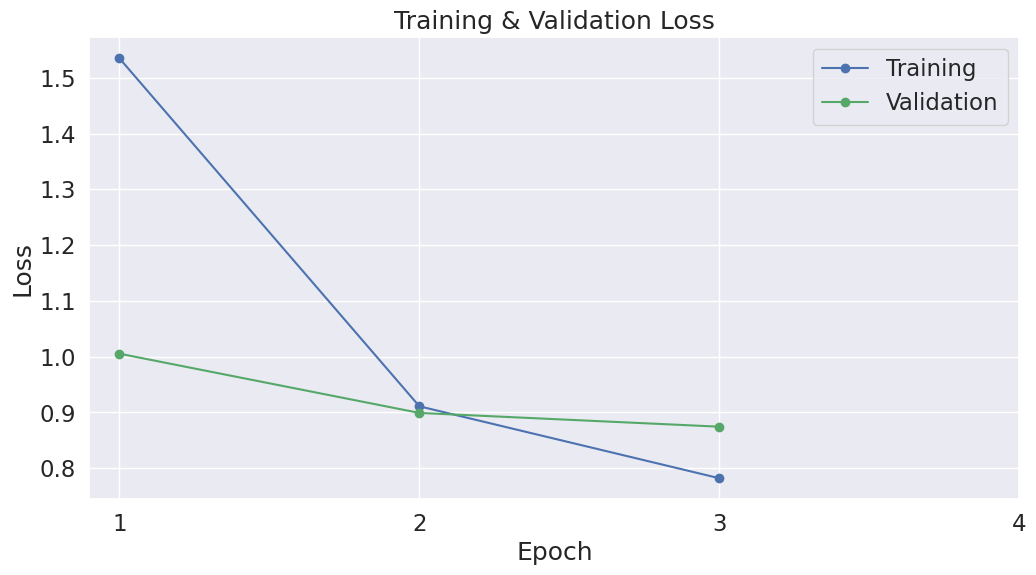

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

The validation loss drops further, but the model is overfitting a lot more.

### ASAP Test (Sets 7-8)

In [ ]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

Predicting labels for 2,292 test sentences...
    DONE.
0.0
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       1.0
           3       0.00      0.00      0.00       1.0
           4       0.00      0.00      0.00       4.0
           5       0.00      0.00      0.00       4.0
           6       0.00      0.00      0.00      20.0
           7       0.00      0.00      0.00      28.0
           8       0.00      0.00      0.00      50.0
           9       0.00      0.00      0.00      49.0
          10       0.00      0.00      0.00      56.0
          11       0.00      0.00      0.00      56.0
          12       0.00      0.00      0.00      86.0
          13       0.00      0.00      0.00      82.0
          14       0.00      0.00      0.00     105.0
          15       0.00      0.00      0.00      86.0
          16       0.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

The model is unable to predict any label correctly. Again, this suggests that simply adding more data isn't useful.

### ELLIPSE Test Set

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)


flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([ 4,  3,  4,  3,  3,  4,  4,  4,  2,  3,  4,  3,  4,  4,  3,  3,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  4,  3,  3,  4,  3,  4,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  4,  4,  3,  2,  3,
        2,  3,  3,  1,  3,  4,  4,  3,  3,  3,  8,  3,  3,  3,  2,  3,  3,
        3,  4,  3,  4,  3,  3,  2,  3,  4,  3,  4,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  2,  3,  2,  2,  1,  2,  4,  3,  1,  2,  3,  3,
        8,  3,  3,  2,  3,  3,  2,  3,  2,  3,  4,  3,  3,  2,  2,  3,  2,
        3,  3,  3,  4,  4,  3,  3,  3,  6,  4,  3,  3,  3,  3,  2,  8,  3,
        2, 10,  3,  4,  4,  3,  3,  2,  3,  2,  2,  3,  3,  2,  2,  3,  2,
        3,  3,  3,  3,  4,  3,  8,  3,  2,  3,  3,  3,  3,  3,  4,  3,  3,
        3,  2,  3,  3,  2,  3,  4,  2,  3,  3,  3,  3,  2,  3,  3,  3,  3,
        3,  3,  3,  4,  3,  2,  4,  3,  3,  3,  1,  3,  3,  3,  8,  3,  3,
        3,  3,  3,  3,  3,  2,  6,  2,  3,  3,  3,  3,  8,  4,  3,  3,  2,
        3,  3,  8,  4,  2

### Distribution Comparisons

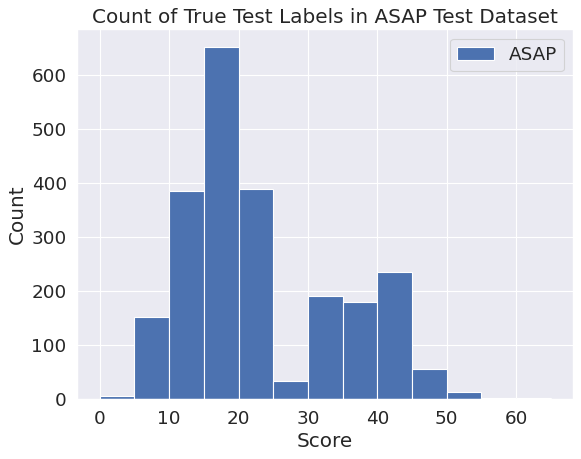

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

For the first time, the true labels do not have have such a strong right skew. Scores between 15 and 20 appear in the ASAP test set the most compared to other bins.

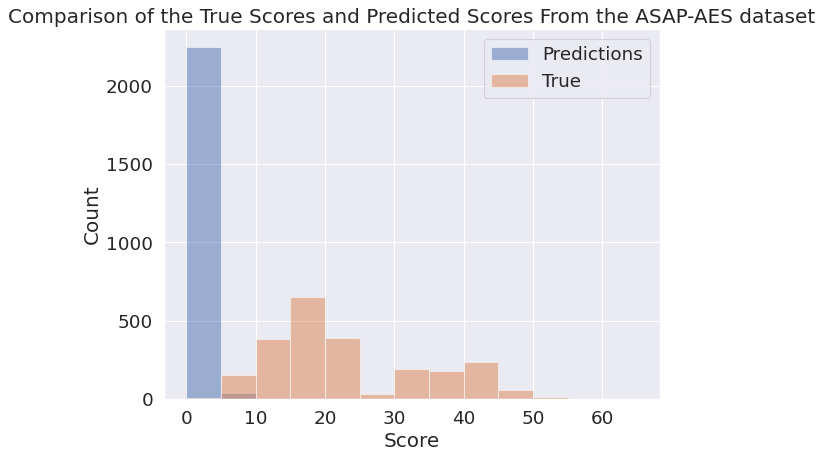

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Due to the training data having a strong right skew, the model can only predict scores that are lower than 5. This means that the scores it produces is largely inaccurate as the test set does not have such a strong data imbalance. This is the most likely reason as to why accuracy plummetted in this iteration of the model.

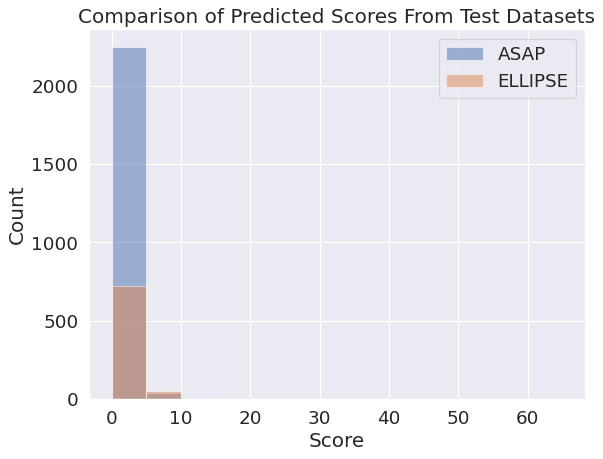

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The model still struggles to predict a score that isn't between 1 and 5. The model does not predict any scores above 10. This is the drop in accuracy. It is likely that the model cannot predict higher numbers due to the frequency of low scores in the training data instead of the actual quality of the essays.

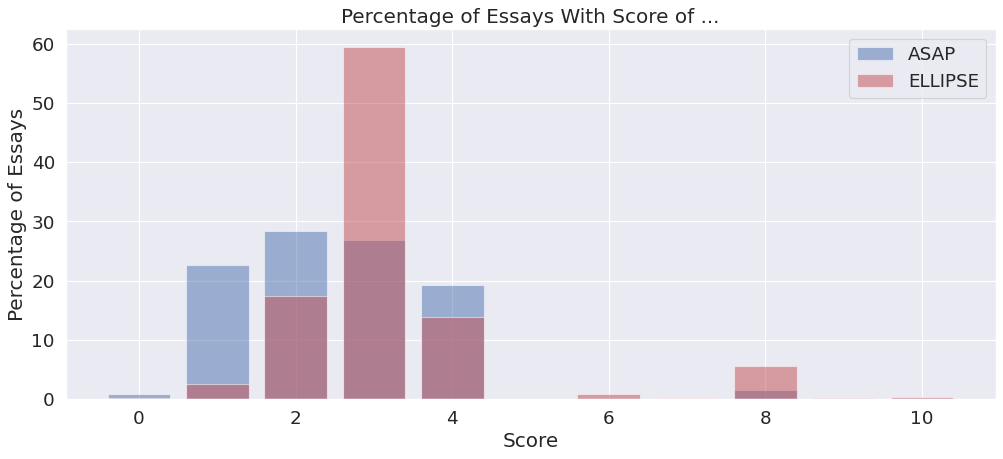

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100


a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

While most of the predicted ASAP scores were between 1-4 with a similar proportion being predicted, the model generally predicts a score of 3 for the ELLIPSE essays. The predicted ELLIPSE scores are generally higher than the predicted ASAP scores.

In [ ]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: -12.702543869772596
P-value: 4.5730356362426365e-36


There is still a difference between the averages of the predicted scores of the ASAP and ELLIPSE test datasets with the ELLIPSE test dataset receiving higher scores.



## Sets 1-7

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
training_stats = []

total_t0 = time.time()

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()

        test = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels)
        loss=test['loss']
        logits=test['logits']

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            temp = model(b_input_ids,
                         token_type_ids=None,
                         attention_mask=b_input_mask,
                         labels=b_labels)
            loss = temp['loss']
            logits = temp['logits']

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

pd.set_option('display.precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    345.    Elapsed: 0:01:53.
  Batch    80  of    345.    Elapsed: 0:03:51.
  Batch   120  of    345.    Elapsed: 0:05:49.
  Batch   160  of    345.    Elapsed: 0:07:47.
  Batch   200  of    345.    Elapsed: 0:09:45.
  Batch   240  of    345.    Elapsed: 0:11:43.
  Batch   280  of    345.    Elapsed: 0:13:41.
  Batch   320  of    345.    Elapsed: 0:15:39.

  Average training loss: 1.78
  Training epoch took: 0:16:52

Running Validation...
  Accuracy: 0.58
  Validation Loss: 1.25
  Validation took: 0:00:38

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    345.    Elapsed: 0:01:56.
  Batch    80  of    345.    Elapsed: 0:03:54.
  Batch   120  of    345.    Elapsed: 0:05:52.
  Batch   160  of    345.    Elapsed: 0:07:50.
  Batch   200  of    345.    Elapsed: 0:09:48.
  Batch   240  of    345.    Elapsed: 0:11:46.
  Batch   280  of    345.    Elapsed: 0:13:44.
  Batch   320  of    345.    Elapsed: 0:15:42.

  Averag

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.78,1.25,0.58,0:16:52,0:00:38
2,1.17,1.10,0.62,0:16:55,0:00:38
3,1.03,1.07,0.62,0:16:55,0:00:38


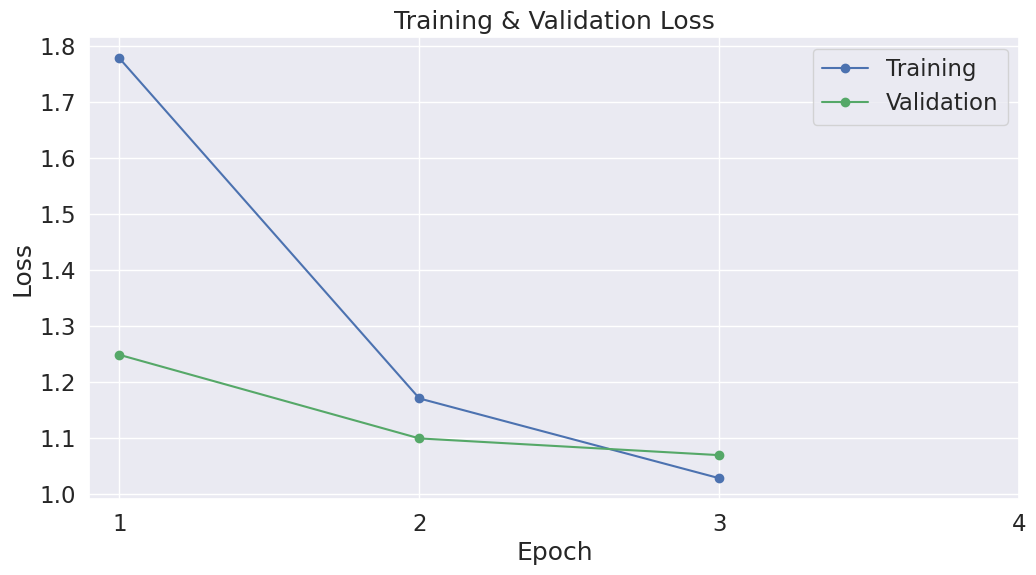

In [ ]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

The loss of the model is higher than the previous models with less sets. Furthermore, the model is still overfitting.

### ASAP Test (Set 8)

In [ ]:
labels_test = torch.tensor(y_test1.values)
prediction_data_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
prediction_sampler_test = SequentialSampler(prediction_data_test)
prediction_dataloader_test = DataLoader(prediction_data_test, sampler=prediction_sampler_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids_test)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader_test:
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

flat_true_labels = np.concatenate(true_labels, axis=0)

accuracy = accuracy_score(flat_true_labels, flat_predictions)
print(accuracy)
print(classification_report(flat_true_labels, flat_predictions))

Predicting labels for 723 test sentences...
    DONE.
0.0
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0
           4       0.00      0.00      0.00       0.0
           8       0.00      0.00      0.00       0.0
           9       0.00      0.00      0.00       0.0
          10       0.00      0.00      0.00       1.0
          15       0.00      0.00      0.00       1.0
          16       0.00      0.00      0.00       0.0
          17       0.00      0.00      0.00       0.0
          20       0.00      0.00      0.00       4.0
          21       0.00      0.00      0.00       2.0
          22       0.00      0.00      0.00       1.0
          24       0.00      0.00      0.00       3.0
          25       0.00      0.00      0.00       5.0
          26       0.00      0.00      0.00       4.0
          27       0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

The model was unable to predict any label correctly in Set 8. Adding more data does not necessarily mean the model is improving.

### ELLIPSE Test Set

In [ ]:
prediction_data_ell_test = TensorDataset(input_ids_ell, attention_masks_ell)
prediction_sampler_ell_test = SequentialSampler(prediction_data_ell_test)
prediction_dataloader_ell_test = DataLoader(prediction_data_ell_test, sampler=prediction_sampler_ell_test, batch_size=batch_size)

In [ ]:
# Global variable settings
seed_val = 0

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model.eval()
predictions_ell_test = []

for batch in prediction_dataloader_ell_test:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()

  predictions_ell_test.append(logits)


flat_predictions_ell = np.concatenate(predictions_ell_test, axis=0)

flat_predictions_ell = np.argmax(flat_predictions_ell, axis=1).flatten()
flat_predictions_ell

array([ 4,  3,  9, 16,  8, 10,  4,  9,  2,  2,  8,  8, 10, 10, 16,  8,  4,
        8,  8,  8,  3,  8,  3,  8,  3,  3,  4,  8, 10,  8, 16,  8,  3, 10,
        2,  8,  8,  3,  3,  8,  3,  8,  8, 16,  3,  1, 16, 10,  2,  2,  8,
        2,  3,  3,  1,  3,  4,  4,  3,  3,  8,  8,  3,  8,  3,  8,  4,  8,
       16, 10,  3,  8,  4,  3,  3,  8,  8,  8,  4,  2,  8,  3,  8,  8,  3,
        3,  2,  8,  8,  8,  2,  3,  2,  2,  1,  2,  4,  4,  8,  8,  8,  3,
        8,  3,  3,  3,  3,  8,  3,  4,  2,  3,  8,  8,  8,  8,  2,  8,  2,
        8, 10,  3,  8,  9,  3,  3,  3,  8,  4,  8,  2,  8, 16,  8,  8,  8,
        2, 10,  3,  8,  4,  4,  3,  2,  8,  2,  8, 16,  8,  8,  8,  8,  2,
        3,  8,  3,  8,  4,  8, 10,  8, 16,  4,  3,  3, 10,  8,  4,  8,  3,
        3,  2,  3,  8,  2,  8,  8,  2,  8,  3,  8,  3,  2,  4,  8,  3,  4,
        3,  8,  8,  9,  8,  2,  4,  2,  4,  8,  1,  2,  8,  3,  8,  3,  8,
        3,  8,  3,  4,  8,  2,  2,  3,  3,  4,  8,  8,  8,  8,  8,  2,  2,
        8,  8,  8, 10,  2

### Distribution Comparisons

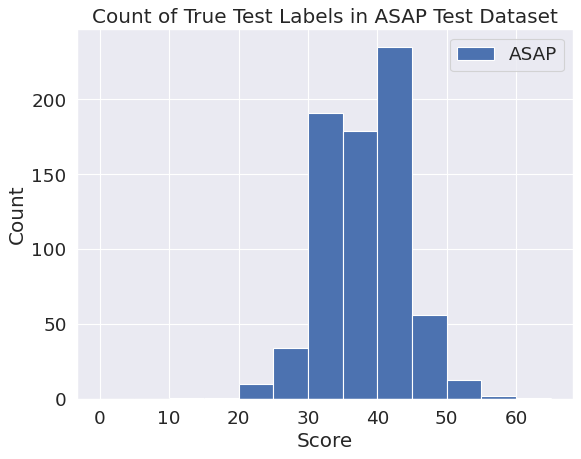

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(flat_true_labels, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Count of True Test Labels in ASAP Test Dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

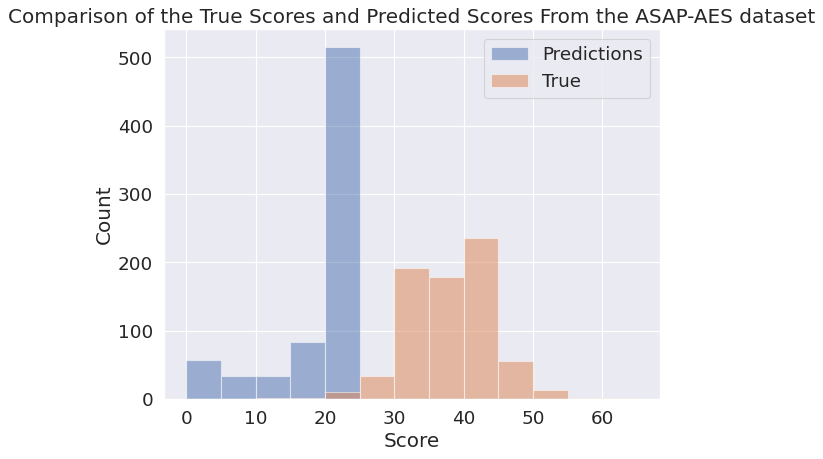

In [ ]:
predictions_asap = flat_predictions.tolist()
predictions_ell = flat_predictions_ell.tolist()

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='Predictions', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(flat_true_labels, alpha=0.5, label='True', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of the True Scores and Predicted Scores From the ASAP-AES dataset')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

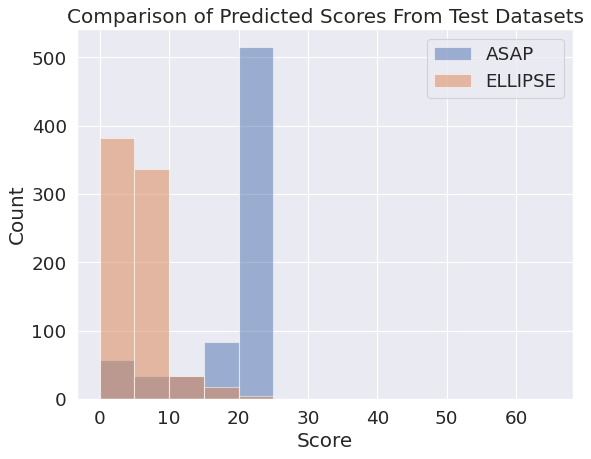

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(predictions_asap, alpha=0.5, label='ASAP', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.hist(predictions_ell, alpha=0.5, label='ELLIPSE', bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 45,50,55,60,65])
plt.legend(loc='upper right')
plt.title('Comparison of Predicted Scores From Test Datasets')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

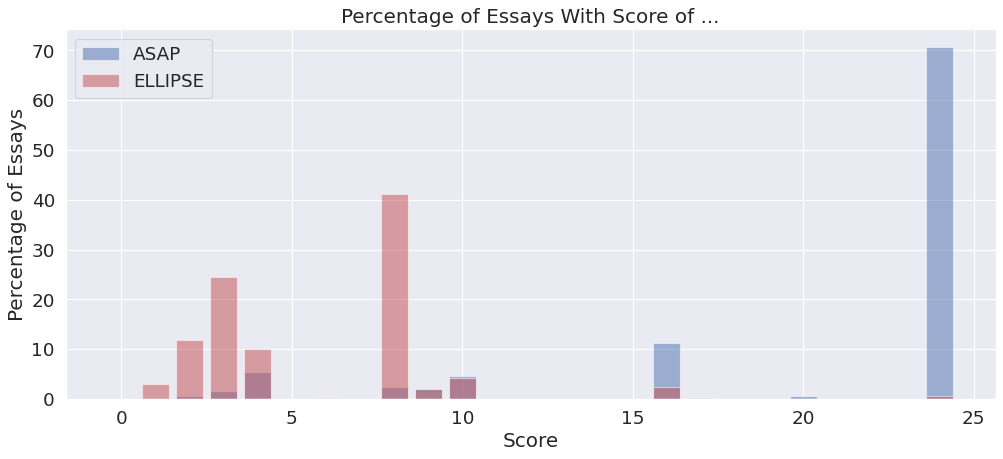

In [ ]:
asap_test_dict = {}
for score in predictions_asap:
  if score not in asap_test_dict.keys():
    asap_test_dict[score] = 0
  asap_test_dict[score] += 1

asap_test_dict_percentage = {}
num_asap_predictions = len(predictions_asap)

for i in range(max(predictions_asap)+1):
  if i not in asap_test_dict.keys():
    asap_test_dict_percentage[i] = 0
  else:
    asap_test_dict_percentage[i] = (asap_test_dict[i]/num_asap_predictions)*100

ell_test_dict = {}
for score in predictions_ell:
  if score not in ell_test_dict.keys():
    ell_test_dict[score] = 0
  ell_test_dict[score] += 1

ell_test_dict_percentage = {}
num_ell_predictions = len(predictions_ell)

for i in range(max(predictions_ell)+1):
  if i not in ell_test_dict.keys():
    ell_test_dict_percentage[i] = 0
  else:
    ell_test_dict_percentage[i] = (ell_test_dict[i]/num_ell_predictions)*100


a = list(asap_test_dict_percentage.keys())
b = list(asap_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_asap'] = b

asap_test_df = pd.DataFrame(data = empty)

a = list(ell_test_dict_percentage.keys())
b = list(ell_test_dict_percentage.values())
empty = {}
empty['score'] = a
empty['percentage_of_ell'] = b

ell_test_df = pd.DataFrame(data = empty)

percentages = asap_test_df.merge(ell_test_df, on=['score'], how='outer')

width = 0.8
plt.figure(figsize=(15, 6), dpi=80)

plt.bar(percentages['score'], percentages['percentage_of_asap'], width=width,
        color='b', label='ASAP', alpha=0.5)
plt.bar(percentages['score'], percentages['percentage_of_ell'],
        width=width, color='r', alpha=0.5, label='ELLIPSE')

plt.legend()
plt.xlabel('Score')
plt.ylabel('Percentage of Essays')
plt.title('Percentage of Essays With Score of ...')
plt.show()

There is suddenly a left skew in the predicted ASAP data with most of the scores being a 24. For the ELLIPSE scores, 8 was being predicted the most often with 3 the second-most often. This is surprising because previous models with less sets struggled to predict any score beyond a 10.

The predicted ASAP scores are generally greater than the predicted ELLIPSE scores.

In [ ]:
t_statistic, p_value = ttest_ind(predictions_asap, predictions_ell)
print(f"t-statistic: {t_statistic}")
print(f"P-value: {p_value}")

t-statistic: 51.73870982860031
P-value: 0.0


The averages of the two dataset predictions are statistically significantly different, but the ASAP dataset contains scores that are higher than the ELLIPSE datasets.

# ELL Comparison Across Sets

As I didn't save the data to files and cleared out the memory, I copied and pasted the ELLIPSE predictions across the different fine-tuned models. This allows me to compare what happens to the ELLIPSE data across the models as more training data was being added, and the different distributions that is contained within the training data.

In [ ]:
s1 = [ 8,  8,  8,  8,  8,  9,  8,  8,  6,  8,  8,  8,  9,  9,  8,  8,  9,
        8,  8,  8,  8,  8,  8,  8,  8,  8, 10,  8,  8,  8,  8,  8,  8, 10,
        8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8, 10,  8,  8,  8,
        6,  8,  8,  6,  8, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8, 10,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8,  8,  8,
        8,  6,  8,  8,  8,  6,  8,  6,  6,  6,  6,  8,  8,  6,  8,  8,  8,
        8,  9,  8,  8,  8,  8,  8,  8,  6,  8,  9,  8,  8,  8,  8,  8,  6,
        8,  8,  8,  8,  9,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,
        6, 10,  8,  8,  8,  8,  8,  8,  8,  6,  6,  8,  8,  6,  6,  8,  6,
        8,  8,  8,  8, 10,  8,  8,  8,  6,  8,  8,  6,  8,  8, 10,  8,  8,
        8,  6,  8,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  8,  6,  8,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  6,  6,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8,
        8,  8,  8,  6,  6,  8,  8,  8,  8,  8,  6,  9,  8,  8,  8,  6,  8,
        8,  8,  9,  8,  8,  6,  8, 10,  8,  8,  6,  8,  9,  8,  8, 10,  8,
        8,  8,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8, 10,  8,  6,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8,  6,
        8,  8,  8,  8,  8,  8,  8,  9,  6,  8,  8,  8,  8,  6,  8,  6, 10,
       10, 10,  8,  8,  8,  8,  6,  6,  9, 10,  8,  8,  8,  6,  8,  8,  8,
        9,  8,  8,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,  6,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8,  6,  8,  8,  8,  8,  6,
        6,  8,  8,  8,  6,  8,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  9,  8,  8,  8,  8,  6,  8,  8,  6,  8,  8,  8,  8,  8,  8,
        8,  6,  8,  8,  8,  8,  8,  8,  8,  9,  6,  6,  8,  8,  8,  6,  8,
        8,  8,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,  6,  8,  6,  8,  8,
        8,  8,  8,  9,  8,  8,  8,  8,  6,  8, 10,  8,  8,  8,  9,  8,  8,
        8,  8,  8,  6,  8,  8,  6,  8,  8,  8,  8,  6,  9,  8,  8, 10,  8,
        8,  8,  8,  8,  8,  8,  8,  6,  8,  6,  8,  8,  8,  6,  8,  8,  8,
        8,  9,  8,  8,  8,  6,  8,  8,  6,  8,  8,  8,  8,  8,  6,  9,  8,
        8,  8,  8,  8,  8,  6,  8,  8,  8,  8,  9, 10,  8,  8,  8,  8,  6,
        8,  8,  8,  8,  8, 10,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8,  8,
        8,  6,  8,  8,  8,  8,  8,  8,  6,  8,  8,  6,  6,  8,  8,  8,  8,
        6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  6,  8,
        8,  8,  8,  8,  8,  6,  6,  8,  8,  8,  8,  8,  6,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8, 10,  8, 10,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,
        8,  8,  8,  8,  8,  6,  9, 10,  6,  8,  8,  8,  8,  6,  8,  8,  6,
        8,  8,  8,  8,  8,  8,  8,  8,  6,  6,  8, 10,  8,  8,  8,  8,  8,
        8,  8,  9,  6,  8,  6,  8,  8,  8,  6,  8,  6,  8,  8,  8,  6,  6,
        8,  8,  8,  8,  8,  8,  8,  8,  6,  6,  8,  8,  8,  8,  8,  6,  6,
        8,  8,  8,  8,  6,  8,  8,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  6,  8,  8,  8,  8, 10,  8,  8,  8,  8,  8,  8,  8,  9,  6,  6,
        6,  8,  8,  8,  8,  8,  6,  8, 10,  8,  8,  8,  6,  8,  8,  8,  6,
        9,  9,  8,  8,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8]

In [ ]:
s2 = [ 8,  3,  8,  3,  3,  8,  8,  8,  3,  3,  8,  3,  9,  8,  8,  8,  8,
        3,  3,  8,  3,  8,  3,  8,  3,  4,  4,  8,  8,  3,  3,  8,  3,  9,
        3,  3,  8,  8,  3,  8,  8,  8,  3,  8,  4,  3,  4,  9,  3,  3,  8,
        3,  8,  4,  3,  8,  9,  4,  8,  3,  8,  8,  3,  8,  3,  3,  8,  8,
        8, 10,  3,  8,  4,  8,  3,  8,  8,  8,  8,  3,  3,  3,  8,  3,  8,
        3,  3,  3,  8,  3,  3,  8,  3,  3,  3,  3,  8,  4,  3,  3,  3,  8,
        3,  4,  8,  3,  8,  8,  3,  8,  3,  3,  8,  3,  3,  3,  3,  8,  3,
        3,  8,  3,  8,  8,  3,  3,  8,  8,  4,  8,  3,  8,  8,  3,  8,  8,
        3, 10,  3,  8,  8,  8,  4,  3,  3,  3,  3,  3,  8,  3,  3,  8,  3,
        3,  8,  8,  8,  9,  8,  8,  3,  3,  4,  3,  3,  8,  3,  4,  3,  3,
        3,  3,  8,  8,  3,  8,  8,  3,  3,  8,  8,  4,  3,  8,  3,  4,  8,
        4,  3,  8,  8,  8,  3,  8,  3,  4,  3,  3,  3,  8,  3,  8,  8,  4,
        8,  3,  3,  8,  4,  3,  3,  3,  3,  4,  3,  8,  8,  8,  8,  3,  3,
        8,  8,  8,  4,  3,  3,  8,  3,  3,  8,  3,  8,  8,  3,  3,  3,  8,
        8,  4,  8,  3,  3,  3,  8,  8,  8,  8,  3,  8,  8,  8,  8,  3,  8,
        8,  3,  8,  3,  8,  3,  3,  4,  8,  3,  8,  8,  8,  3,  3,  4,  8,
        3,  8,  3,  3,  4,  8,  8,  8,  3,  8,  4,  8,  3,  3, 10,  3,  3,
        8,  8,  3,  8,  8,  8,  8,  3,  4,  3,  8,  3,  8,  3,  3,  3,  3,
        8,  3,  8,  8,  3,  3,  8,  8,  3,  4,  3,  3,  8,  3,  8,  3, 10,
       10, 10,  8,  8,  3,  8,  3,  3,  8, 10,  3,  3,  8,  3,  8,  8,  8,
        8,  8,  8,  8,  8,  3,  3,  8,  8,  3,  8,  3,  8,  3,  3,  3,  8,
        3,  4,  3,  8,  3, 10,  3,  8,  3,  3,  3,  3,  8,  3,  8,  4,  3,
        3,  8,  8,  8,  8,  8,  3,  3,  4,  8,  8,  8,  8,  8,  8,  3,  3,
        8,  3,  8,  8,  8,  8,  8,  3,  3,  8,  3,  8,  8,  8,  8,  8,  8,
        3,  3,  8,  3,  3,  3,  3,  8,  4,  8,  3,  3,  8,  3,  8,  3,  8,
        8,  3,  3,  8,  3,  3,  3,  3,  3,  3,  8,  4,  3,  8,  3,  3,  3,
        8,  8,  3,  8,  3,  8,  8,  8,  3,  3,  9,  3,  8,  3,  4,  3,  8,
        3,  8,  8,  3,  8,  3,  3,  4,  3,  4,  3,  3, 10,  3,  4,  9,  8,
        8,  4,  8,  8,  3,  8,  8,  3,  3,  3,  4,  8,  3,  3,  8,  8,  3,
        8, 10,  8,  4,  3,  3,  3,  8,  3,  8,  3,  8,  8,  3,  3,  8,  8,
        3,  8,  8,  8,  3,  3,  8,  3,  8,  8,  8, 10,  3,  4,  3,  8,  3,
        3,  3,  8,  8,  3,  4,  8,  3,  3,  8,  8,  8,  3,  3,  8,  3,  8,
        8,  3,  8,  8,  4,  3,  3,  8,  3,  8,  8,  3,  3,  3,  4,  4,  8,
        3,  8,  3,  4,  3,  8,  8,  8,  8,  8,  3,  3,  3,  8,  3,  3,  8,
        8,  3,  3,  8,  8,  3,  3,  8,  4,  4,  8,  8,  3,  8,  3,  8,  3,
        3,  8,  8,  8,  8,  3,  3,  8,  9,  3, 10,  8,  4,  8,  8,  3,  8,
        3,  3,  3,  8,  3,  3,  3,  4,  8,  4,  8,  3,  8,  8,  8, 10,  4,
        3,  8,  3,  8,  3,  3,  9, 10,  3,  8,  8,  3,  4,  3,  3,  3,  3,
        3,  3,  8,  4,  4,  8,  8,  8,  3,  3,  3,  8,  3,  3,  8,  8,  3,
        8,  8,  8,  3,  8,  3,  3,  8,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        4,  3,  3,  8,  4,  8,  3,  8,  3,  3,  3,  8,  8,  4,  3,  3,  3,
        3,  4,  3,  3,  3,  3,  8,  3,  3,  8,  3,  8,  4,  8,  8,  8,  8,
        3,  3,  3,  3,  8,  4,  8,  8,  3,  8,  3,  3,  8,  4, 10,  3,  3,
        3,  3,  3,  8,  3,  8,  3,  8,  8,  8,  8,  8,  8,  8,  8,  3,  3,
        8,  8,  8,  8,  3,  3,  3,  3,  3,  8,  3,  3,  3,  8,  3,  3,  8,
        8,  3,  3,  3,  3,  8,  8,  3, 10]

In [ ]:
s3 = [ 8,  3, 10,  3,  8, 10, 10, 10,  3,  8,  8,  8, 10, 10,  3,  8,  4,
        3,  8,  8,  3,  8,  3,  8,  3,  8,  4,  8, 10,  8,  8,  8,  3, 10,
        3,  1,  8,  8,  3,  8,  3,  8,  3,  8,  3,  2,  3, 10,  3,  2,  8,
        3,  8,  3,  1,  8,  4,  4,  8,  3,  8,  8,  3,  3,  3,  3,  8,  8,
        3, 10,  3,  8,  3,  8,  3,  8,  8,  8, 10,  3,  3,  3,  3,  3,  3,
        8,  2,  3,  8,  8,  2,  3,  3,  2,  1,  3,  4,  3,  1,  3,  3,  3,
        7,  4,  3,  3,  8,  3,  8,  8,  2,  3, 10,  3,  8,  1,  3,  8,  3,
        8, 10,  3,  8, 10,  3,  8,  8,  6,  3,  4,  3,  8,  8,  1,  8, 10,
        2, 10,  3, 10, 10, 10,  3,  3,  3,  1,  1,  3,  8,  2,  1,  8,  3,
        8,  8,  3, 10,  4,  8,  8,  3,  2,  3,  8,  3,  8,  8,  4,  3,  3,
        3,  2,  8,  8,  3,  8, 10,  2,  8,  3,  8,  3,  3,  3,  7,  3,  3,
        3,  3,  8, 10,  3,  1,  4,  3,  3,  3,  1,  3,  8,  8,  8,  3,  3,
        3,  8,  3,  3,  3,  3,  1,  2,  3,  3,  3,  8,  8,  4,  8,  3,  2,
        8,  3,  8,  3,  2,  3,  8,  3,  3,  8,  3,  3,  8,  3,  3,  2,  3,
        3,  3,  8,  1,  1,  2,  8,  8,  8,  8,  2,  3, 10,  8,  8,  3,  8,
        8,  1, 10,  3,  8,  2,  3, 10,  8,  8,  1,  8, 10,  8,  3,  4,  8,
        3,  8,  7,  3,  3,  3,  3, 10,  3,  3,  4,  3,  2,  3, 10,  8,  1,
        8, 10,  8,  8,  8,  8,  8,  2,  4,  3,  8,  3,  8,  3,  2,  3,  2,
        8,  3, 10, 10,  8,  3, 10,  4,  1,  8,  3,  3,  3,  2,  8,  1, 10,
       10,  4,  8,  8,  3,  3,  2,  2, 10, 10,  3,  2,  8,  1,  4,  3,  8,
        4,  8,  3,  3,  8,  2,  2,  4,  8,  3,  8,  3,  3,  1,  8,  3,  8,
        3,  3,  3,  8,  2,  8,  3,  3,  2,  2,  3,  3,  3,  3,  8,  3,  3,
        1,  8,  8,  8,  1,  8,  2,  1,  3,  3,  3,  8,  8,  3,  8,  8,  6,
        8,  8, 10,  3,  8,  8,  8,  1,  3,  8,  2,  8,  8,  8,  8,  3,  3,
        3,  1,  8,  8,  3,  2,  8,  8,  3,  3,  1,  3,  8,  3,  3,  6,  8,
        8,  3,  1,  3,  3,  1,  3,  3,  3,  3,  8,  3,  1,  8,  2,  3,  8,
        8,  8,  3, 10,  3,  8,  3,  8,  1,  8, 10,  2,  3,  3,  4,  3,  8,
        3,  3,  3,  1,  3,  3,  1,  3,  2,  3,  1,  1, 10,  3,  8, 10,  8,
        2,  3,  8,  8,  3,  8,  3,  1,  3,  1,  3,  8,  2,  1,  8,  8,  2,
        8, 10,  8,  8,  3,  2,  3,  3,  2,  8,  3,  3,  3,  3,  3,  4, 10,
        3,  4,  8,  8,  3,  1,  8,  3,  8, 10, 10, 10,  1,  3,  3, 10,  1,
        3,  3,  8,  3,  3,  4,  8,  3,  1,  8,  9,  8,  3,  3,  8,  8,  8,
        8,  1,  8,  8,  3,  3,  2,  3,  3,  8,  8,  2,  1,  8,  3,  3,  3,
        1,  8,  3,  8,  3,  8,  8,  8,  8,  3,  3,  3,  8,  8,  3,  1,  8,
        3,  1,  2,  3,  8,  2,  3,  8,  3,  4, 10,  3,  2,  8,  3, 10,  3,
        3,  8, 10,  8,  8,  7,  3,  8, 10,  8, 10,  8,  3,  8,  3,  8, 10,
        3,  3,  8,  8,  2,  3,  8,  3,  8,  3,  8,  6,  8,  4,  8, 10, 10,
        8,  8,  2, 10,  7,  3, 10, 10,  2, 10,  8,  1,  3,  1,  3,  3,  3,
        3,  8,  8,  8,  8,  3,  9,  8,  1,  2,  3, 10,  2,  1,  8,  3,  3,
        8,  8,  3,  1,  8,  2,  1,  8,  8,  2,  1,  3,  3,  3,  3,  3,  2,
        3,  3,  3, 10,  8,  3,  8,  8,  2,  2,  3,  8,  8,  3,  3,  1,  2,
        2,  3,  8,  7,  1,  3,  8,  2,  1,  8,  3,  8, 10,  8,  8,  8,  8,
        3,  1,  3,  3,  8,  3, 10,  8,  1,  8,  3,  3,  8,  3, 10,  3,  2,
        1,  3,  3,  8,  1,  8,  3,  3,  4, 10,  3,  3,  1,  8,  4,  1,  2,
        4, 10,  8, 10,  1,  1,  1,  3,  6,  3,  3,  1,  3, 10,  7,  2,  3,
        8,  3,  3,  8,  2,  8,  8,  3, 10]

In [ ]:
s4 = [ 4,  3,  4,  3,  3,  4,  4,  4,  2,  3,  4,  3,  4,  4,  3,  8,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  4,  3,  3,  4,  3,  4,
        3,  3,  8,  3,  3,  3,  3,  3,  3,  3,  3,  2,  4,  4,  3,  3,  3,
        3,  3,  3,  2,  3,  4,  4,  3,  2,  3,  8,  3,  3,  3,  3,  3,  3,
        3,  4,  3,  3,  3,  3,  3,  3,  3,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  3,  3,  2,  2,  1,  3,  4,  3,  1,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  3,  2,  3,  3,
        3,  4,  3,  8,  4,  3,  3,  3,  3,  3,  4,  3,  3,  3,  2,  8,  4,
        2, 10,  3,  4,  4,  4,  3,  3,  3,  3,  2,  3,  3,  3,  2,  3,  3,
        3,  3,  3,  4,  4,  3,  8,  3,  3,  3,  3,  3,  3,  3,  4,  3,  3,
        3,  2,  3,  3,  3,  8,  3,  2,  3,  3,  3,  4,  2,  3,  3,  3,  3,
        4,  3,  3, 10,  3,  2,  4,  3,  4,  3,  2,  3,  3,  3,  8,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  2,  3,  3,  3,  3,  8,  4,  3,  2,  3,
        3,  3,  8,  4,  2,  3,  3,  3,  3,  3,  3,  3,  8,  3,  3,  2,  3,
        3,  3,  3,  2,  2,  2,  4,  8,  3,  3,  2,  4,  8,  3,  3,  3,  3,
        3,  3,  8,  3,  3,  2,  3, 10,  3,  3,  2,  3,  4,  3,  3,  4,  3,
        3,  3,  3,  3,  3,  3,  3,  4,  3,  3,  4,  3,  2,  3, 10,  3,  3,
        8,  4,  3,  3,  3,  3,  8,  2,  4,  3,  3,  3,  3,  3,  2,  3,  2,
        3,  3,  4,  4,  3,  3,  8,  4,  2,  4,  3,  2,  3,  3,  3,  2, 10,
        4,  4,  8,  3,  3,  3,  3,  2,  4,  4,  3,  2,  8,  2,  4,  3,  3,
        4,  8,  3,  3,  3,  2,  2,  4,  8,  3,  3,  3,  3,  2,  3,  3,  3,
        3,  3,  3,  3,  2,  8,  3,  3,  2,  2,  3,  3,  3,  3,  8,  3,  3,
        1,  4,  3,  8,  2,  8,  3,  1,  3,  3,  3,  8,  3,  3,  4,  3,  3,
        3,  3,  4,  3,  3,  3,  3,  2,  3,  4,  2,  4,  8,  4,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  8,  3,  4,  2,  3,  3,  3,  3,  3,  3,
        8,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  3,  2,  3,  3,
        3,  3,  2,  8,  3,  8,  3,  3,  1,  3,  4,  2,  4,  3,  4,  3,  3,
        3,  3,  3,  2,  3,  3,  2,  4,  3,  3,  3,  1,  9,  3,  3,  4,  3,
        3,  3,  8,  3,  3,  3,  3,  3,  3,  1,  3,  8,  2,  2,  3,  3,  2,
        3,  4,  3,  3,  2,  2,  3,  3,  3,  8,  3,  3,  3,  3,  3,  4,  8,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4, 10,  2,  4,  3,  4,  2,
        3,  3,  3,  3,  3,  4,  3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,
        3,  2,  8,  3,  3,  2,  3,  4,  3,  3,  3,  2,  2,  3,  3,  4,  3,
        2,  3,  3,  3,  3,  3,  8,  3,  3,  4,  3,  3,  3,  3,  3,  2,  8,
        3,  3,  3,  3,  3,  2,  3,  3,  3,  4,  4,  3,  2,  3,  3,  4,  3,
        3,  3,  4,  3,  3,  3,  3,  4,  4,  3,  4,  4,  4,  3,  3,  3,  4,
        3,  3,  3,  8,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  8, 10,  4,
        3,  3,  2,  3,  3,  3,  4, 10,  3,  4,  3,  2,  4,  2,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  3,  2,  2,  3,  4,  2,  3,  3,  3,  3,
        3,  3,  3,  1,  3,  2,  3,  3,  3,  2,  2,  3,  3,  3,  3,  3,  2,
        4,  3,  3,  4,  3,  3,  3,  3,  2,  2,  3,  3,  3,  4,  3,  2,  2,
        2,  3,  3,  3,  3,  3,  3,  2,  1,  8,  3,  8,  4,  3,  4,  8,  3,
        3,  1,  3,  3,  3,  3,  4,  3,  3,  8,  3,  3,  8,  3,  4,  3,  3,
        1,  2,  3,  3,  3,  3,  3,  3,  4,  4,  4,  3,  2,  4,  4,  3,  2,
        4,  4,  3,  4,  2,  2,  2,  3,  3,  3,  3,  3,  3,  4,  3,  2,  4,
        4,  3,  3,  3,  2,  8,  3,  3,  4]

In [ ]:
s5 = [ 4,  3,  4,  3,  3,  4,  4,  4,  2,  3,  4,  3,  4,  4,  3,  4,  4,
        3,  3,  3,  3,  3,  3,  4,  3,  3,  4,  3,  4,  3,  3,  4,  3,  4,
        2,  2,  3,  3,  3,  4,  4,  3,  3,  3,  4,  1,  4,  4,  3,  3,  3,
        3,  3,  3,  1,  4,  4,  4,  3,  2,  3,  8,  3,  4,  3,  3,  3,  3,
        3,  4,  3,  4,  4,  3,  3,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  2,  3,  2,  2,  1,  2,  4,  3,  1,  3,  3,  3,
        8,  4,  3,  3,  3,  3,  3,  3,  2,  3,  4,  3,  3,  3,  3,  3,  2,
        3,  4,  3,  4,  4,  3,  3,  3,  2,  4,  4,  3,  3,  3,  1,  4,  4,
        2, 10,  3,  4,  4,  4,  3,  3,  3,  2,  2,  3,  3,  2,  1,  3,  2,
        3,  3,  3,  4,  4,  3,  3,  2,  2,  4,  3,  3,  4,  3,  4,  3,  3,
        3,  2,  3,  3,  3,  3,  4,  2,  3,  3,  4,  4,  2,  3,  2,  3,  4,
        4,  3,  3,  4,  3,  2,  4,  3,  4,  3,  1,  3,  4,  3,  8,  3,  4,
        4,  3,  3,  4,  3,  2,  1,  2,  3,  3,  3,  3,  8,  4,  3,  3,  2,
        3,  3,  8,  4,  2,  3,  3,  2,  3,  3,  3,  4,  4,  3,  3,  2,  3,
        3,  3,  3,  2,  1,  2,  4,  4,  3,  4,  2,  4,  4,  3,  3,  3,  4,
        4,  2, 10,  3,  3,  2,  3,  4,  3,  3,  1,  4,  4,  3,  3,  4,  3,
        3,  3,  3,  2,  4,  3,  3,  4,  2,  3,  4,  3,  2,  3,  4,  3,  8,
        8,  4,  3,  3,  3,  3,  4,  2,  4,  3,  3,  3,  3,  3,  2,  3,  2,
        4,  3,  4,  4,  3,  3,  4,  4,  2,  4,  3,  2,  3,  2,  3,  1, 10,
        4,  4,  8,  3,  3,  4,  3,  2,  4, 10,  3,  2,  8,  1,  4,  3,  3,
        4,  4,  3,  3,  3,  2,  2,  4,  8,  3,  3,  3,  3,  1,  3,  3,  3,
        3,  4,  3,  3,  2,  8,  3,  4,  2,  2,  3,  3,  3,  3,  8,  4,  2,
        1,  4,  3,  8,  1,  4,  3,  1,  3,  4,  3,  4,  3,  3,  4,  4,  3,
        4,  3,  4,  4,  3,  3,  3,  2,  3,  4,  2,  4,  8,  4,  4,  3,  3,
        3,  2,  3,  3,  2,  2,  3,  8,  3,  4,  2,  8,  3,  3,  3,  8,  4,
        8,  3,  2,  3,  3,  2,  3,  3,  3,  3,  3,  4,  1,  3,  2,  3,  3,
        3,  3,  3,  4,  3,  4,  3,  3,  1,  3,  4,  2,  4,  3,  4,  3,  3,
        3,  4,  3,  2,  3,  3,  2,  4,  2,  3,  3,  1, 10,  3,  3,  4,  4,
        2,  3,  4,  3,  3,  3,  4,  1,  3,  1,  4,  8,  2,  1,  4,  3,  3,
        3,  4,  3,  3,  3,  2,  3,  3,  2,  3,  3,  3,  3,  3,  3,  4,  4,
        3,  4,  3,  4,  3,  2,  3,  3,  3,  4,  4, 10,  2,  4,  3,  4,  2,
        3,  3,  3,  3,  3,  4,  3,  3,  3,  4,  4,  3,  2,  3,  8,  3,  4,
        3,  1,  4,  3,  4,  2,  2,  4,  3,  4,  3,  2,  2,  3,  3,  4,  4,
        1,  3,  3,  3,  3,  4,  8,  3,  3,  4,  3,  3,  3,  3,  3,  1,  8,
        3,  2,  2,  3,  3,  1,  3,  3,  3,  4,  4,  3,  2,  3,  3,  4,  3,
        3,  3,  4,  3,  3,  3,  3,  4,  4,  3,  4,  4,  4,  3,  3,  3,  4,
        3,  3,  3,  3,  2,  3,  8,  3,  3,  4,  4,  8,  3,  4,  8, 10,  4,
        3,  3,  2,  4,  2,  3,  4,  4,  2,  4,  3,  2,  4,  1,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  3,  2,  2,  3,  4,  3,  3,  3,  3,  3,
        3,  3,  4,  1,  3,  1,  2,  3,  3,  2,  3,  3,  3,  3,  3,  3,  2,
        4,  3,  3,  4,  4,  4,  3,  4,  2,  2,  3,  4,  3,  4,  3,  1,  2,
        2,  4,  3,  3,  1,  3,  3,  2,  1,  8,  3,  8,  4,  3,  4,  8,  4,
        3,  1,  3,  3,  4,  3,  4,  3,  1,  3,  3,  3,  8,  3,  4,  3,  2,
        1,  3,  3,  4,  1,  3,  3,  4,  4,  4,  4,  3,  1,  4,  4,  3,  2,
        4,  4,  3,  4,  2,  2,  2,  3,  2,  3,  3,  2,  3,  4,  2,  2,  4,
        4,  3,  3,  3,  2,  8,  3,  3,  4]

In [ ]:
s6 = [ 4,  3,  4,  3,  3,  4,  4,  4,  2,  3,  4,  3,  4,  4,  3,  3,  4,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  3,  4,  3,  3,  4,  3,  4,
        2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  2,  4,  4,  3,  2,  3,
        2,  3,  3,  1,  3,  4,  4,  3,  3,  3,  8,  3,  3,  3,  2,  3,  3,
        3,  4,  3,  4,  3,  3,  2,  3,  4,  3,  4,  3,  3,  3,  3,  3,  3,
        3,  2,  3,  3,  3,  2,  3,  2,  2,  1,  2,  4,  3,  1,  2,  3,  3,
        8,  3,  3,  2,  3,  3,  2,  3,  2,  3,  4,  3,  3,  2,  2,  3,  2,
        3,  3,  3,  4,  4,  3,  3,  3,  6,  4,  3,  3,  3,  3,  2,  8,  3,
        2, 10,  3,  4,  4,  3,  3,  2,  3,  2,  2,  3,  3,  2,  2,  3,  2,
        3,  3,  3,  3,  4,  3,  8,  3,  2,  3,  3,  3,  3,  3,  4,  3,  3,
        3,  2,  3,  3,  2,  3,  4,  2,  3,  3,  3,  3,  2,  3,  3,  3,  3,
        3,  3,  3,  4,  3,  2,  4,  3,  3,  3,  1,  3,  3,  3,  8,  3,  3,
        3,  3,  3,  3,  3,  2,  6,  2,  3,  3,  3,  3,  8,  4,  3,  3,  2,
        3,  3,  8,  4,  2,  3,  3,  2,  3,  3,  3,  4,  4,  3,  3,  2,  3,
        3,  3,  3,  2,  2,  2,  4,  3,  3,  3,  2,  3,  4,  3,  3,  3,  4,
        3,  8,  8,  3,  3,  2,  3,  4,  3,  3,  2,  3,  4,  2,  3,  4,  3,
        3,  3,  3,  2,  4,  3,  3,  4,  2,  3,  3,  3,  2,  3,  4,  3,  7,
        8,  4,  3,  3,  3,  3,  3,  2,  4,  3,  3,  3,  3,  3,  2,  3,  2,
        3,  3,  4,  3,  3,  3,  4,  4,  2,  3,  3,  2,  3,  2,  3,  2, 10,
        4,  4,  8,  3,  3,  3,  2,  2,  4,  4,  3,  2,  8,  2,  4,  3,  8,
        3,  4,  3,  3,  3,  2,  2,  4,  8,  3,  3,  3,  3,  2,  3,  3,  3,
        2,  3,  3,  8,  2,  8,  2,  3,  2,  2,  3,  2,  3,  3,  8,  4,  2,
        1,  4,  3,  8,  2,  8,  3,  1,  3,  4,  3,  3,  3,  3,  3,  4,  2,
        3,  2,  4,  3,  3,  3,  3,  2,  3,  4,  2,  4,  8,  4,  3,  3,  3,
        3,  2,  3,  3,  2,  2,  3,  3,  3,  4,  2,  2,  3,  3,  3,  8,  3,
        8,  3,  2,  3,  3,  8,  3,  3,  3,  3,  3,  8,  1,  3,  2,  3,  3,
        3,  3,  3,  3,  3,  8,  3,  3,  2,  3,  4,  2,  3,  3,  4,  3,  3,
        3,  3,  3,  1,  3,  3,  2,  4,  2,  3,  3,  0,  9,  3,  3,  4,  3,
        3,  3,  8,  3,  3,  3,  3,  6,  3,  1,  3,  8,  2,  2,  3,  3,  2,
        3,  3,  3,  3,  3,  2,  3,  3,  2,  3,  3,  3,  3,  3,  3,  3,  4,
        3,  3,  8,  3,  3,  2,  3,  3,  3,  4,  4,  8,  2,  4,  3,  4,  2,
        3,  3,  3,  3,  3,  4,  3,  3,  2,  3,  4,  3,  2,  3,  8,  3,  3,
        3,  2,  4,  3,  3,  2,  2,  4,  3,  3,  3,  2,  2,  3,  3,  3,  3,
        1,  3,  3,  3,  2,  3,  8,  3,  3,  4,  3,  3,  3,  3,  3,  1,  8,
        3,  3,  2,  3,  3,  1,  2,  3,  3,  4,  4,  3,  2,  3,  3,  4,  3,
        3,  3,  4,  3,  3,  3,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,  4,
        3,  3,  3,  3,  2,  3,  8,  3,  3,  3,  3,  8,  3,  4,  8,  8,  4,
        3,  3,  2,  3,  8,  3,  4,  4,  2,  4,  3,  2,  3,  1,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  2,  2,  3,  4,  2,  2,  3,  3,  3,
        3,  3,  3,  1,  3,  1,  2,  3,  3,  2,  3,  3,  3,  3,  3,  3,  2,
        3,  3,  3,  4,  3,  3,  3,  3,  2,  2,  3,  3,  3,  3,  3,  2,  2,
        2,  4,  3,  3,  6,  3,  3,  2,  1,  8,  3,  8,  4,  3,  4,  8,  3,
        3,  1,  3,  3,  3,  3,  3,  3,  6,  4,  3,  3,  8,  3,  4,  2,  2,
        1,  2,  3,  3,  6,  3,  3,  3,  4,  3,  4,  3,  1,  4,  3,  3,  2,
        3,  4,  3,  4,  2,  2,  2,  3,  2,  3,  3,  2,  3,  3,  8,  2,  4,
        4,  3,  3,  3,  2,  8,  3,  3,  4]

In [ ]:
s7 = [ 4,  3,  9, 16,  8, 10,  4,  9,  2,  2,  8,  8, 10, 10, 16,  8,  4,
        8,  8,  8,  3,  8,  3,  8,  3,  3,  4,  8, 10,  8, 16,  8,  3, 10,
        2,  8,  8,  3,  3,  8,  3,  8,  8, 16,  3,  1, 16, 10,  2,  2,  8,
        2,  3,  3,  1,  3,  4,  4,  3,  3,  8,  8,  3,  8,  3,  8,  4,  8,
       16, 10,  3,  8,  4,  3,  3,  8,  8,  8,  4,  2,  8,  3,  8,  8,  3,
        3,  2,  8,  8,  8,  2,  3,  2,  2,  1,  2,  4,  4,  8,  8,  8,  3,
        8,  3,  3,  3,  3,  8,  3,  4,  2,  3,  8,  8,  8,  8,  2,  8,  2,
        8, 10,  3,  8,  9,  3,  3,  3,  8,  4,  8,  2,  8, 16,  8,  8,  8,
        2, 10,  3,  8,  4,  4,  3,  2,  8,  2,  8, 16,  8,  8,  8,  8,  2,
        3,  8,  3,  8,  4,  8, 10,  8, 16,  4,  3,  3, 10,  8,  4,  8,  3,
        3,  2,  3,  8,  2,  8,  8,  2,  8,  3,  8,  3,  2,  4,  8,  3,  4,
        3,  8,  8,  9,  8,  2,  4,  2,  4,  8,  1,  2,  8,  3,  8,  3,  8,
        3,  8,  3,  4,  8,  2,  2,  3,  3,  4,  8,  8,  8,  8,  8,  2,  2,
        8,  8,  8, 10,  2,  3,  3,  2,  3,  8,  3,  4, 10,  3,  3,  2,  8,
        3,  3,  8,  2,  8,  2,  8,  8,  8,  3,  8,  4, 10,  8,  8,  3,  8,
        4,  8, 10,  3,  8,  2,  8, 10,  3,  3,  2,  8,  8,  3,  3,  4, 16,
        3,  8,  8,  2,  4,  3,  3,  8,  8,  3,  3,  8,  2,  8, 10,  3,  8,
        8, 24,  3,  8,  8,  8,  8,  3,  4,  3,  8,  3,  8,  3,  2,  3,  2,
        8,  3,  4,  8,  3,  3,  8,  8,  8,  8,  8,  2,  3,  8,  8,  8, 10,
       10, 10,  8,  8,  3,  4,  3,  2,  8, 10,  3,  2,  8,  1,  8,  3,  8,
        4,  8, 24,  3,  3,  2,  2,  9,  8,  3,  3,  8, 16,  8,  8,  3,  3,
        3,  4,  3,  8,  8,  8,  2,  4,  3,  2,  8,  3,  8,  3,  8,  4,  2,
        1,  8,  8,  8,  8,  8,  2,  1,  3,  8,  8,  8,  8,  3,  8,  4,  3,
        8,  2,  9,  3,  3,  8,  8,  2,  3,  9,  2,  8,  8,  8,  8, 16,  3,
        8,  8,  4,  8,  8,  8,  8,  8,  8,  4,  2,  3,  8,  3,  3,  8,  4,
        8,  3,  8,  8,  3,  8,  8,  8,  3,  3,  3,  8,  1,  8,  2,  8,  8,
        8,  8,  3, 10,  8,  8,  3,  4,  1, 16,  4,  2,  4,  8,  4,  8,  8,
        8,  8,  4,  1,  4,  3,  2,  4,  3,  4,  3,  1, 10,  8,  8, 10,  9,
        8,  3,  8,  4,  3,  4,  4,  8,  8,  1,  3,  8,  3,  8,  3,  3,  2,
        8,  4,  8,  3,  3,  2,  3,  8,  8,  8,  8,  8,  3,  3, 16,  3,  8,
        3,  4,  8,  3,  8,  8,  8,  3,  8,  8,  8, 10,  1,  4,  8,  9,  2,
        8,  4,  8,  8,  8,  4,  3,  8,  2,  8,  9,  8,  8,  3,  8,  3,  8,
        8,  2, 10,  8,  4,  2,  2,  8,  3,  8,  3,  2,  1, 16,  3,  4,  3,
        1,  8,  8,  4,  2,  4,  8,  8,  8,  4,  3,  8,  8,  8,  3,  1,  8,
        3,  8,  2,  3, 16,  2,  2,  8,  3,  4,  4,  3,  2,  8,  2,  8,  4,
        3,  8,  8,  3,  8,  8,  3,  8, 10,  8, 24,  8,  3,  8,  8,  8,  8,
        8,  8,  3,  3,  2,  8,  8,  3,  8,  3,  8,  8,  8,  8,  8, 10,  3,
        8,  8,  2,  8,  8,  3, 10, 24,  2,  8,  8,  3,  8,  2,  3,  3,  3,
        3,  8,  8,  8,  3,  3,  8,  3,  1,  2,  3,  9,  2,  3,  8,  3,  8,
        8,  8,  4,  1,  8,  1,  2,  8,  8,  2,  3,  3,  3,  8,  3,  8,  2,
        4,  3,  8,  8,  8,  4,  8,  4,  8,  2,  8, 10,  8,  4, 16,  8,  6,
        8,  4,  3,  8,  8,  3,  4,  2,  1,  8,  8,  8,  8,  3,  4,  8,  8,
        8,  1,  3,  3,  8,  4,  4,  3,  8, 24,  3,  2,  9,  4, 10,  2, 16,
        1,  2,  3,  8,  8,  8,  3,  4,  9,  4,  9,  3,  8,  9,  3,  8,  2,
        4,  9,  8, 10,  2,  2,  2,  3,  1,  8,  3,  8,  3,  8,  8,  2,  8,
        8,  8,  3,  8,  2,  8,  8,  8, 10]

In [ ]:
# This is taken from workbook 2
s8 = [10,  8, 10, 20,  8, 10, 10, 10,  2,  8,  8,  8, 10, 10, 40, 10, 10,
       20,  8, 10,  8, 10,  4,  9,  3,  3,  4, 10, 10,  8,  8, 10,  8, 10,
        8,  8, 10,  8,  8,  8, 40,  8,  8,  8,  4, 16, 40, 10,  2,  2,  8,
        6,  8,  8,  1,  8,  4, 10,  8, 16, 10,  8,  8, 10,  2,  6,  8,  8,
       20, 40,  3,  9,  4,  8,  2,  8, 10, 10, 10,  8,  8,  3,  8,  6,  3,
        8,  1, 20,  8,  8,  2,  8,  8,  6,  1,  2, 10, 10,  8,  8, 21, 10,
        8, 10,  8,  8,  8,  8,  2,  8,  2,  8, 10, 16,  8, 16,  2,  8,  8,
        8, 40,  8, 10, 10,  8,  8,  8,  6, 10, 10,  8,  8,  8,  6,  8, 10,
        1, 10,  8, 10, 10, 10,  4, 16,  8,  6,  6, 16,  8,  6,  6,  8,  2,
        8,  8, 10, 10, 10,  8, 40,  8, 16,  4,  8,  2, 10,  8, 10,  8,  2,
        3,  1,  3,  8,  3,  9, 10, 16,  8,  8, 10,  3,  2,  8,  8,  8,  8,
       10,  8,  8, 10,  8,  1, 10,  3,  4,  8,  1,  8,  8,  8,  8, 10, 10,
       10,  8,  8, 40, 10,  2,  6,  2,  4, 10,  8,  8,  8,  8,  8,  3,  2,
        8,  8,  8, 40,  1,  3,  8,  6,  8,  8, 20,  4, 10,  8,  8,  2,  8,
        8,  8,  8,  2,  6,  2, 10,  8,  8,  8, 16, 10, 10, 10,  8,  8, 10,
       10,  8, 10,  4,  8,  2,  8, 10,  8,  8,  2, 10, 10,  8,  3,  4,  8,
        3, 10,  8,  2,  4,  4,  8, 10,  8,  8, 10,  8,  2, 16, 10,  8,  6,
        8, 10,  8,  8, 10,  8, 10,  8,  4, 40,  8,  3,  8,  3,  6,  3,  1,
       10,  8, 10, 10,  8,  8, 10, 10,  6, 10,  8,  2,  4,  2,  8,  8, 10,
       40, 10,  8, 10,  3,  8, 16,  2, 10, 10,  1,  8,  8,  1, 10,  8,  8,
       10,  8, 40,  8,  8,  2,  2, 10,  8,  8,  8,  8, 20,  6,  8,  8,  8,
        8, 10,  8,  8, 16,  9,  8,  4,  1,  2,  8,  8,  8,  8,  8, 10,  3,
        1, 10,  8,  8,  6, 10,  2,  1,  8, 10,  8,  8,  8,  8, 10, 10,  8,
        9,  8, 10, 40,  8,  8, 10,  2,  3, 10,  2, 10,  8, 10, 10,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8, 10,  6,  8, 10,  8,  8,  8, 10,
        8,  8,  9, 10,  8,  8, 40,  8,  4,  4,  8,  8,  8,  8,  1,  8, 40,
        8,  8,  8, 10,  8,  8,  8,  8,  1, 40, 10, 17,  4,  8,  4,  8, 10,
        8, 10, 10,  6,  8,  8,  2, 10,  6,  8,  2,  1, 10,  8,  8, 10, 10,
        8,  8,  8, 10, 16,  8,  8,  6,  8,  1,  4,  8, 17,  6,  8,  8,  6,
        8, 10,  8, 10,  8,  1,  2,  8,  8, 10,  8, 10,  8,  8, 20, 10, 10,
        8, 10,  8, 10,  8,  6, 10,  3,  8, 10, 10, 10,  6,  4,  8, 10,  1,
        8, 10,  8,  8, 16,  4,  8, 20,  6, 10, 10,  8,  6,  8,  8,  8, 10,
        8,  6, 10,  8,  4,  1,  2, 40,  3, 10,  8,  2,  6, 20, 10, 10,  4,
        1,  8,  8,  8,  3, 10,  8,  8,  8, 10,  8,  8,  8,  8,  2,  1,  8,
        4,  8,  2,  8,  8,  1,  2,  8,  4,  4, 10,  4,  2,  8,  8, 10, 10,
        8,  8, 10,  8,  8, 20,  3, 10, 10,  8, 40, 10,  4,  8,  8,  8, 10,
        8,  8,  3,  8, 16,  8,  8,  3,  8,  4,  8,  8,  8, 10,  8, 10, 10,
        8,  8,  1, 10,  8,  8, 10, 40,  6, 10,  8,  8, 10,  1,  3, 10,  2,
        8,  8,  8, 10,  4,  8, 10,  8,  1,  1, 10, 10,  1,  8,  8,  8,  8,
        8,  8, 10,  1,  8,  1,  2,  8,  8,  8,  8,  8,  2,  8,  8,  8,  2,
       10,  4,  8, 10, 10,  8,  8, 10,  6,  2,  8, 40,  8,  8,  8,  1,  6,
        6,  4,  8,  8,  6,  2,  4,  2,  1,  8, 10,  8, 10, 10, 10,  8, 10,
        8,  1,  2,  8, 10, 40, 10,  8,  8, 40,  8,  3, 10,  4, 10,  8, 16,
        1,  2,  8,  8,  6,  8,  3,  8, 10, 10, 10,  8,  8, 10,  4,  8,  1,
       10, 10,  8, 40,  2,  1,  1,  8,  1,  8,  2,  6,  3, 10,  6,  2, 10,
       10,  8,  8,  8,  2,  8,  6,  8, 10]

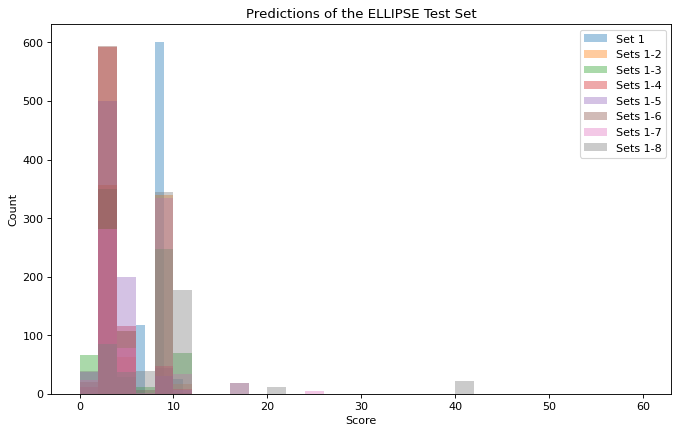

In [ ]:
plt.figure(figsize=(10, 6), dpi=80)
plt.hist(s1, alpha=0.4, label='Set 1', bins=range(0,30,1))
plt.hist(s2, alpha=0.4, label='Sets 1-2', bins=range(0,61,2))
plt.hist(s3, alpha=0.4, label='Sets 1-3', bins=range(0,61,2))
plt.hist(s4, alpha=0.4, label='Sets 1-4', bins=range(0,61,2))
plt.hist(s5, alpha=0.4, label='Sets 1-5', bins=range(0,61,2))
plt.hist(s6, alpha=0.4, label='Sets 1-6', bins=range(0,61,2))
plt.hist(s7, alpha=0.4, label='Sets 1-7', bins=range(0,61,2))
plt.hist(s8, alpha=0.4, label='Sets 1-8', bins=range(0,61,2))
plt.legend(loc='upper right')
plt.title('Predictions of the ELLIPSE Test Set')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Looking at the histogram, most of the predictions are between 2 and 4 no matter which sets are in the training set, except when the training set is only Set 1 where it mostly predicts an 8. As it's hard to visually analyze the predictions since there are so many overlapping shades and colors, I created a stacked bar chart.

In [ ]:
possible_scores = range(0,61,1)
s1_counts = pd.DataFrame(s1, columns = ["s1"]).value_counts().reset_index()
s2_counts = pd.DataFrame(s2, columns = ["s2"]).value_counts().reset_index()
s3_counts = pd.DataFrame(s3, columns = ["s3"]).value_counts().reset_index()
s4_counts = pd.DataFrame(s4, columns = ["s4"]).value_counts().reset_index()
s5_counts = pd.DataFrame(s5, columns = ["s5"]).value_counts().reset_index()
s6_counts = pd.DataFrame(s6, columns = ["s6"]).value_counts().reset_index()
s7_counts = pd.DataFrame(s7, columns = ["s7"]).value_counts().reset_index()
s8_counts = pd.DataFrame(s8, columns = ["s8"]).value_counts().reset_index()


use  = pd.DataFrame(possible_scores, columns=["score"])
set1_ell = use.merge(s1_counts, how="left", left_on=["score"], right_on=["s1"])
set1_ell.fillna(0, inplace=True)

set2_ell = use.merge(s2_counts, how="left", left_on=["score"], right_on=["s2"])
set2_ell.fillna(0, inplace=True)

set3_ell = use.merge(s3_counts, how="left", left_on=["score"], right_on=["s3"])
set3_ell.fillna(0, inplace=True)

set4_ell = use.merge(s4_counts, how="left", left_on=["score"], right_on=["s4"])
set4_ell.fillna(0, inplace=True)

set5_ell = use.merge(s5_counts, how="left", left_on=["score"], right_on=["s5"])
set5_ell.fillna(0, inplace=True)

set6_ell = use.merge(s6_counts, how="left", left_on=["score"], right_on=["s6"])
set6_ell.fillna(0, inplace=True)

set7_ell = use.merge(s7_counts, how="left", left_on=["score"], right_on=["s7"])
set7_ell.fillna(0, inplace=True)

set8_ell = use.merge(s8_counts, how="left", left_on=["score"], right_on=["s8"])
set8_ell.fillna(0, inplace=True)

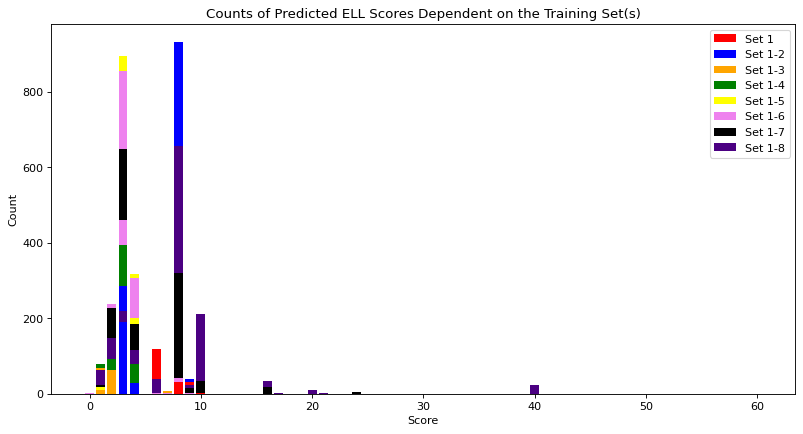

In [ ]:
x = set1_ell["score"]
y1 = set1_ell["count"]
y2 = set2_ell["count"]
y3 = set3_ell["count"]
y4 = set4_ell["count"]
y5 = set5_ell["count"]
y6 = set6_ell["count"]
y7 = set7_ell["count"]
y8 = set8_ell["count"]

plt.figure(figsize=(12, 6), dpi=80)
plt.bar(x, y1, color='r', label="Set 1")
plt.bar(x, y2, bottom=y1, color='b', label="Set 1-2")
plt.bar(x, y3, bottom=y2, color='orange', label="Set 1-3")
plt.bar(x, y4, bottom=y3, color='green', label="Set 1-4")
plt.bar(x, y5, bottom=y4, color='yellow', label="Set 1-5")
plt.bar(x, y6, bottom=y5, color='violet', label="Set 1-6")
plt.bar(x, y7, bottom=y6, color='black', label="Set 1-7")
plt.bar(x, y8, bottom=y7, color='indigo', label="Set 1-8")
plt.legend(loc='upper right')
plt.title("Counts of Predicted ELL Scores Dependent on the Training Set(s)")
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

With the inclusion of Sets 7 and 8 in the training data, the model was able to predict larger numbers. Most of the ELL Predictions stayed between 2-5, and 8, but it is possible for the model to predict larger numbers when the training data also includes larger numbers.

I would expect the same essay to be scored the same no matter what it is being compared to, but it's not. For example, if I write an essay about future aspirations as a 10th grader, I wouldn't expect an essay another 10th grader wrote about schools to influence my score.

# Conclusions

Adding more data to the models helps to an extent in predicting accurate scores, but simply adding data isn't a solution. It can even prevent the model from predicting any scores accurately if the model is trained on imbalanced data or if the training data does not contain examples of the scores in the test set.

The ASAP-AES dataset generally contains essays with low scores. This causes a problem when it is used as part of the training set, because it struggles to predict higher scores due to the data imbalance. The predicted scores were very different when Set 6 and 7 were added to the training set.

Without an equivalent label in the ELLIPSE dataset, I can't assess the accuracy of the predicted scores, but I can gleam some insight when I compare their distribution across the models as the test dataset did not vary like the ASAP did when I split it up by sets. Despite the continuous change in the training set, the models generally gives it a similar bimodal distribution with scores between 3-5, and 8. The proportions varied somewhat, but the overall shape of the  distribution remained mostly similar upon visual analysis. However, this shows that even the same essays can receive different scores, just depending on what data the model was trained on.

Generally the ELLIPSE essays received higher predicted scores than the ASAP essays did. It is ambiguous whether it is because the essays were better written, the essays were longer, or some other reason.

It is difficult to create an AES that can produce accurate scores, much less an AES that can produce accurate scores across various topics. There are limitations with this experiment though, because not all the essays were scored similar across the essay sets that were placed in training.

When the training data is updated, the model's performance must be re-evaluated. The drastic difference in predicted scores in the last two models also highlight how predicted scores can "swing" to another mode (score that is seen the most frequently) based on added data. Thus, a model can't simply be re-trained with additional data with every iteration of the essay when the prompt and scoring guidelines shift.